In [1]:
import pandas as pd
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import json
import os
from pandas import json_normalize
# import seaborn as sns
import math

from utils import *
from eyetracking import *
from load import *
from plotting import *


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update({
    # 'figure.figsize': (3.35, 2.5),   # 单栏尺寸
    'font.family': 'Arial',
    'axes.labelsize': 7,
    'axes.titlesize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.linewidth': 0.75,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 2,
    'ytick.major.size': 2,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'legend.loc': 'upper right'
})

In [3]:
csv_path  = '/Users/lijialin/Desktop/Research/proj-two-stage-task/data/processed/eyetracking/'
json_path = '/Users/lijialin/Desktop/Research/proj-two-stage-task/data/processed/trial_data/'

participants = [f'P{i}' for i in range(3, 20)]  # P3..P19

# ----- Run the loader -----
all_eye, all_trials_list, all_trials_df = load_all_participants(csv_path, json_path, participants)

print("Eyetracking shape:", all_eye.shape)
print("Trials (list) len:", len(all_trials_list))
print("Trials (DataFrame) shape:", all_trials_df.shape)

# Quick peek
display(all_eye.head())
display(all_trials_df.head())

Eyetracking shape: (17700029, 28)
Trials (list) len: 3013
Trials (DataFrame) shape: (3013, 62)


,Type,Event,Visit,Switch,Time,TimeEvent,Offset,trial_index,Node,X,...,Eye,Start_X,Start_Y,End_X,End_Y,Amplitude,Peak_Velocity,Start_Node,End_Node,wid
0,Message,begin drift_check,0.0,0.0,4062.135000,351.602524,0.000000,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P3
1,Message,initialize,0.0,0.0,4065.553000,355.019302,-0.001222,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P3
2,Message,start recording,0.0,0.0,4065.553000,355.019646,-0.000878,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P3
3,Gaze,NaN,NaN,NaN,355.026524,NaN,NaN,1,8.0,995.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P3
4,Gaze,NaN,NaN,NaN,355.027524,NaN,NaN,1,8.0,994.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P3


,kind,graph,rewards,initial_stage,hide_states,hide_rewards_while_acting,hide_edges_while_acting,gaze_contingent,gaze_tolerance,fixation_lag,...,reward_info.0.desc,reward_info.0.image,reward_info.1.desc,reward_info.1.image,reward_info.2.desc,reward_info.2.image,reward_info.3.desc,reward_info.3.image,reward_info.4.desc,reward_info.4.image
0,GraphTrial,"[[], [0, 4], [9, 5], [], [8], [7], [1, 0], [],...","[1, 0, None, 1, -2, 4, 0, 0, -2, 1, -3]",planning,False,False,False,False,1.5,0.5,...,pattern_5,images[4],pattern_6,images[5],pattern_7,images[6],pattern_8,images[7],pattern_9,images[8]
1,GraphTrial,"[[9, 8], [], [0, 7], [], [1], [3, 4], [], [6],...","[-2, 2, None, -1, 3, 4, 4, 4, -2, 0, 3]",planning,False,False,False,False,1.5,0.5,...,pattern_5,images[4],pattern_6,images[5],pattern_7,images[6],pattern_8,images[7],pattern_9,images[8]
2,GraphTrial,"[[], [2], [], [], [], [0], [8, 5], [10, 1], []...","[3, 2, 2, -4, -2, -2, 2, None, -1, -1, 1]",planning,False,False,False,False,1.5,0.5,...,pattern_5,images[4],pattern_6,images[5],pattern_7,images[6],pattern_8,images[7],pattern_9,images[8]
3,GraphTrial,"[[5], [7, 10], [6, 3], [], [], [], [3, 0], [9,...","[-3, None, 4, -1, -4, -1, 3, -3, 2, 3, 1]",planning,False,False,False,False,1.5,0.5,...,pattern_5,images[4],pattern_6,images[5],pattern_7,images[6],pattern_8,images[7],pattern_9,images[8]
4,GraphTrial,"[[4, 5], [], [], [6, 1], [8, 10], [2, 9], [1, ...","[None, 3, 4, -4, -2, 4, 0, -2, -2, -3, -4]",planning,False,False,False,False,1.5,0.5,...,pattern_5,images[4],pattern_6,images[5],pattern_7,images[6],pattern_8,images[7],pattern_9,images[8]


In [4]:
res = compute_fixation_by_stage_and_node(
    eye_tracking_df=all_eye,        # or eye_tracking_df if single subject, still fine
    behavior_obj=all_trials_list,   # or {'trials': all_trials_list}
    AOI_r=100.0,
    include_zero_rows=True
)

display(res.head())

,wid,trial_index,stage,node,layer_type,reward,fixation_duration,fixation_count,tree_type,path,node_identity,choice,answer
0,P10,1,0,0,other,-4.0,0.0,0,tree2,None,None,0,0
1,P10,1,0,1,other,NaN,0.0,0,tree2,root,None,0,0
2,P10,1,0,2,first_layer,3.0,0.0,0,tree2,right,R,0,0
3,P10,1,0,3,second_layer,-3.0,0.0,0,tree2,path4,RR,0,0
4,P10,1,0,4,other,0.0,0.0,0,tree2,None,None,0,0


In [5]:
stage1 = res[res['stage'] == 1]
stage2 = res[res['stage'] == 2]

stage1[(stage1['trial_index'] == 1) & (stage1['wid'] == 'P3')]

,wid,trial_index,stage,node,layer_type,reward,fixation_duration,fixation_count,tree_type,path,node_identity,choice,answer
75625,P3,1,1,0,other,1.0,0.178,1,tree1,None,None,0,0
75626,P3,1,1,1,other,0.0,0.199,1,tree1,None,None,0,0
75627,P3,1,1,2,other,NaN,0.284,1,tree1,root,None,0,0
75628,P3,1,1,3,second_layer,1.0,0.000,0,tree1,path1,LL,0,0
75629,P3,1,1,4,other,-2.0,0.000,0,tree1,None,None,0,0
75630,P3,1,1,5,first_layer,4.0,0.002,1,tree1,right,R,0,1
75631,P3,1,1,6,other,0.0,0.007,1,tree1,None,None,0,0
75632,P3,1,1,7,second_layer,0.0,0.071,4,tree1,path3,RL,0,0
75633,P3,1,1,8,other,-2.0,0.027,2,tree1,None,None,0,0
75634,P3,1,1,9,first_layer,1.0,0.219,3,tree1,left,L,1,0


In [6]:
stage2[(stage2['trial_index'] == 1) & (stage2['wid'] == 'P3')]

,wid,trial_index,stage,node,layer_type,reward,fixation_duration,fixation_count,tree_type,path,node_identity,choice,answer
75636,P3,1,2,0,other,1.0,0.000,0,tree1,None,None,0,0
75637,P3,1,2,1,other,0.0,0.000,0,tree1,None,None,0,0
75638,P3,1,2,2,other,NaN,0.003,1,tree1,root,None,0,0
75639,P3,1,2,3,second_layer,1.0,0.808,4,tree1,path1,LL,1,0
75640,P3,1,2,4,other,-2.0,0.734,9,tree1,None,None,0,0
75641,P3,1,2,5,first_layer,4.0,0.767,6,tree1,right,R,0,0
75642,P3,1,2,6,other,0.0,0.055,7,tree1,None,None,0,0
75643,P3,1,2,7,second_layer,0.0,0.195,7,tree1,path3,RL,0,1
75644,P3,1,2,8,other,-2.0,0.947,10,tree1,None,None,0,0
75645,P3,1,2,9,first_layer,1.0,1.760,20,tree1,left,L,0,0


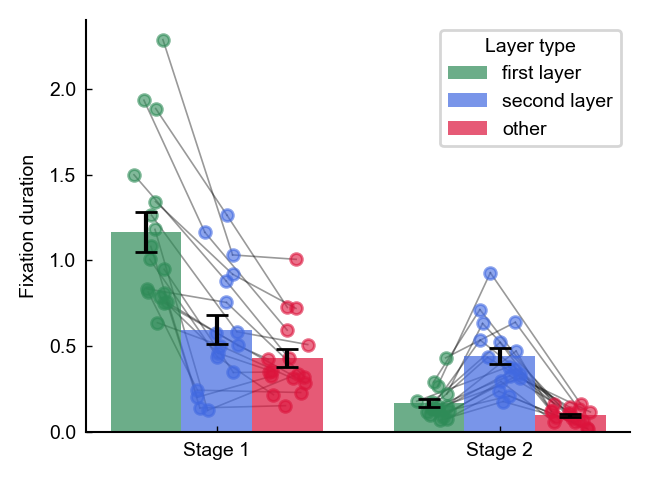

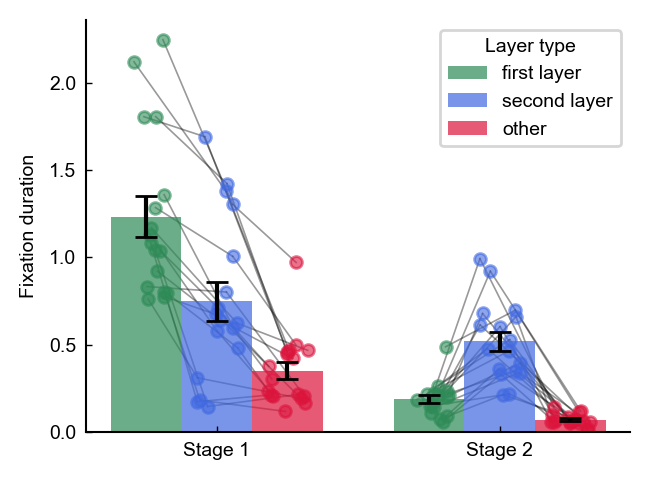

In [7]:
plot_fixation_bars(res)

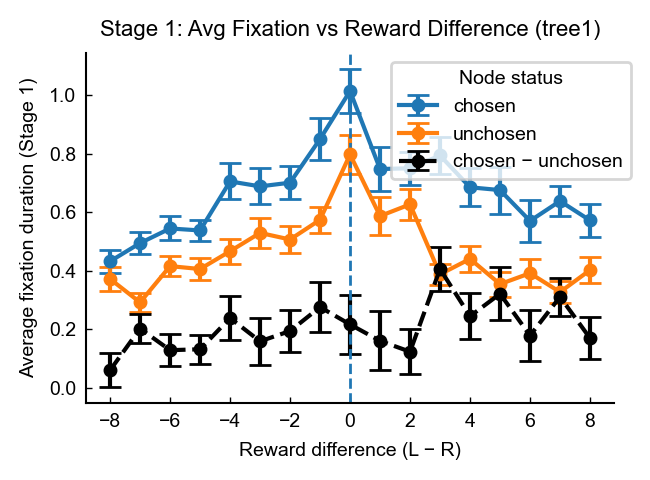

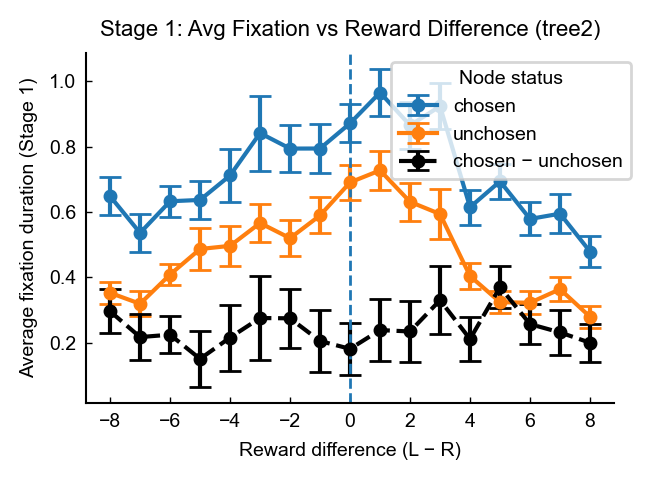

In [10]:
def plot_stage1_avg_fixation_vs_reward_diff_with_diff(res: pd.DataFrame):
    """
    For Stage 1 only, split by tree_type ('tree1', 'tree2'):
      - Compute reward difference: reward(L) - reward(R) per (wid, trial_index)
      - Average fixation_duration for chosen vs unchosen nodes at each reward_diff level
      - Compute the difference (chosen - unchosen) fixation_duration
      - Plot all three curves (chosen, unchosen, difference) for each tree_type separately
    """
    needed = {'wid','trial_index','stage','node_identity','reward','fixation_duration','choice','tree_type'}
    missing = needed - set(res.columns)
    if missing:
        raise ValueError(f"`res` missing required columns: {missing}")

    # Keep Stage 1, only first-layer nodes L and R
    df = res[(res['stage'] == 1) & (res['node_identity'].isin(['L','R']))].copy()

    # Ensure numeric reward
    df['reward'] = pd.to_numeric(df['reward'], errors='coerce')
    df = df.dropna(subset=['reward'])

    for ttype in ['tree1', 'tree2']:
        df_t = df[df['tree_type'] == ttype].copy()
        if df_t.empty:
            continue

        # Compute reward difference per trial
        rewards_pivot = (
            df_t.pivot_table(index=['wid','trial_index'],
                             columns='node_identity',
                             values='reward',
                             aggfunc='first')
              .reset_index()
        )
        rewards_pivot = rewards_pivot.dropna(subset=['L','R'])
        rewards_pivot['reward_diff'] = rewards_pivot['L'] - rewards_pivot['R']

        # Merge reward_diff back
        df_plot = df_t.merge(rewards_pivot[['wid','trial_index','reward_diff']],
                             on=['wid','trial_index'],
                             how='inner')

        # Label chosen vs unchosen
        df_plot['chosen_flag'] = np.where(df_plot['choice'] == 1, 'chosen', 'unchosen')

        # Group by reward_diff and chosen_flag to average fixation
        avg_df = (
            df_plot.groupby(['reward_diff','chosen_flag'])['fixation_duration']
                   .agg(['mean','sem'])
                   .reset_index()
        )

        # Pivot so chosen & unchosen are columns
        pivot_avg = avg_df.pivot(index='reward_diff', columns='chosen_flag', values='mean')
        pivot_sem = avg_df.pivot(index='reward_diff', columns='chosen_flag', values='sem')

        # Compute difference (chosen - unchosen)
        diff_df = pd.DataFrame({
            'reward_diff': pivot_avg.index,
            'mean': pivot_avg['chosen'] - pivot_avg['unchosen'],
            'sem': np.sqrt(pivot_sem['chosen']**2 + pivot_sem['unchosen']**2)  # propagated SEM
        }).dropna()

        # Plot
        fig, ax = plt.subplots(figsize=(3.35, 2.5))

        # Chosen & unchosen
        for label, sub in avg_df.groupby('chosen_flag'):
            ax.errorbar(
                sub['reward_diff'],
                sub['mean'],
                yerr=sub['sem'],
                fmt='o-',
                label=label,
                capsize=4,
                markersize=4
            )

        # Difference line
        ax.errorbar(
            diff_df['reward_diff'],
            diff_df['mean'],
            yerr=diff_df['sem'],
            fmt='o--',
            color='black',
            label='chosen − unchosen',
            capsize=4,
            markersize=4
        )

        ax.axvline(0.0, linestyle='--', linewidth=1)
        ax.set_xlabel('Reward difference (L − R)')
        ax.set_ylabel('Average fixation duration (Stage 1)')
        ax.set_title(f'Stage 1: Avg Fixation vs Reward Difference ({ttype})')

        # legend outside
        ax.legend(
            title='Node status',
            fontsize=7,
            bbox_to_anchor=(1.05, 1),
            borderaxespad=0.5,
            title_fontsize=7
        )
        plt.tight_layout()
        plt.show()

# ---- usage ----
plot_stage1_avg_fixation_vs_reward_diff_with_diff(res)

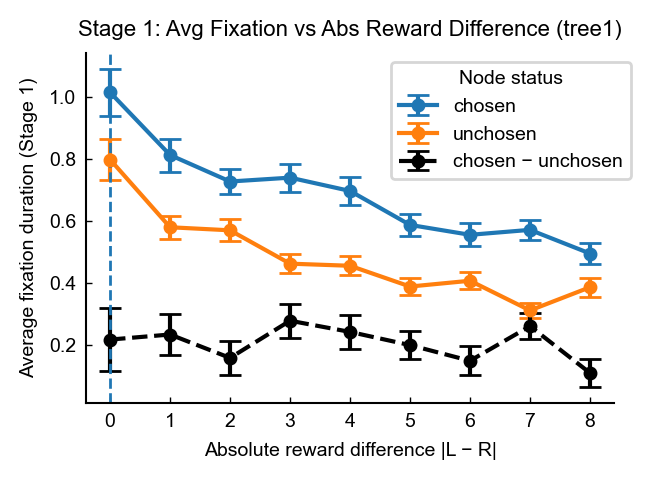

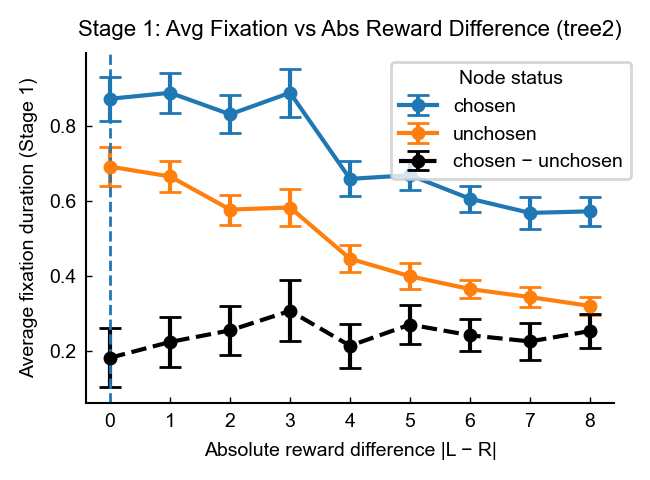

In [11]:
def plot_stage1_avg_fixation_vs_abs_reward_diff_with_diff(res: pd.DataFrame):
    """
    For Stage 1 only, split by tree_type ('tree1', 'tree2'):
      - Compute absolute reward difference: |reward(L) - reward(R)| per (wid, trial_index)
      - Average fixation_duration for chosen vs unchosen nodes at each abs_reward_diff level
      - Compute the difference (chosen - unchosen) fixation_duration
      - Plot all three curves (chosen, unchosen, difference) for each tree_type separately
    """
    needed = {'wid','trial_index','stage','node_identity','reward','fixation_duration','choice','tree_type'}
    missing = needed - set(res.columns)
    if missing:
        raise ValueError(f"`res` missing required columns: {missing}")

    # Keep Stage 1, only first-layer nodes L and R
    df = res[(res['stage'] == 1) & (res['node_identity'].isin(['L','R']))].copy()

    # Ensure numeric reward
    df['reward'] = pd.to_numeric(df['reward'], errors='coerce')
    df = df.dropna(subset=['reward'])

    for ttype in ['tree1', 'tree2']:
        df_t = df[df['tree_type'] == ttype].copy()
        if df_t.empty:
            continue

        # Compute absolute reward difference per trial
        rewards_pivot = (
            df_t.pivot_table(index=['wid','trial_index'],
                             columns='node_identity',
                             values='reward',
                             aggfunc='first')
              .reset_index()
        )
        rewards_pivot = rewards_pivot.dropna(subset=['L','R'])
        rewards_pivot['abs_reward_diff'] = (rewards_pivot['L'] - rewards_pivot['R']).abs()

        # Merge abs_reward_diff back
        df_plot = df_t.merge(rewards_pivot[['wid','trial_index','abs_reward_diff']],
                             on=['wid','trial_index'],
                             how='inner')

        # Label chosen vs unchosen
        df_plot['chosen_flag'] = np.where(df_plot['choice'] == 1, 'chosen', 'unchosen')

        # Group by abs_reward_diff and chosen_flag to average fixation
        avg_df = (
            df_plot.groupby(['abs_reward_diff','chosen_flag'])['fixation_duration']
                   .agg(['mean','sem'])
                   .reset_index()
        )

        # Pivot so chosen & unchosen are columns
        pivot_avg = avg_df.pivot(index='abs_reward_diff', columns='chosen_flag', values='mean')
        pivot_sem = avg_df.pivot(index='abs_reward_diff', columns='chosen_flag', values='sem')

        # Compute difference (chosen - unchosen)
        diff_df = pd.DataFrame({
            'abs_reward_diff': pivot_avg.index,
            'mean': pivot_avg['chosen'] - pivot_avg['unchosen'],
            'sem': np.sqrt(pivot_sem['chosen']**2 + pivot_sem['unchosen']**2)  # propagated SEM
        }).dropna()

        # Plot
        fig, ax = plt.subplots(figsize=(3.35, 2.5))

        # Chosen & unchosen
        for label, sub in avg_df.groupby('chosen_flag'):
            ax.errorbar(
                sub['abs_reward_diff'],
                sub['mean'],
                yerr=sub['sem'],
                fmt='o-',
                label=label,
                capsize=4,
                markersize=4
            )

        # Difference line
        ax.errorbar(
            diff_df['abs_reward_diff'],
            diff_df['mean'],
            yerr=diff_df['sem'],
            fmt='o--',
            color='black',
            label='chosen − unchosen',
            capsize=4,
            markersize=4
        )

        ax.axvline(0.0, linestyle='--', linewidth=1)
        ax.set_xlabel('Absolute reward difference |L − R|')
        ax.set_ylabel('Average fixation duration (Stage 1)')
        ax.set_title(f'Stage 1: Avg Fixation vs Abs Reward Difference ({ttype})')

        # legend outside
        ax.legend(
            title='Node status',
            fontsize=7,
            bbox_to_anchor=(1.05, 1),
            borderaxespad=0.5,
            title_fontsize=7
        )
        plt.tight_layout()
        plt.show()

plot_stage1_avg_fixation_vs_abs_reward_diff_with_diff(res)

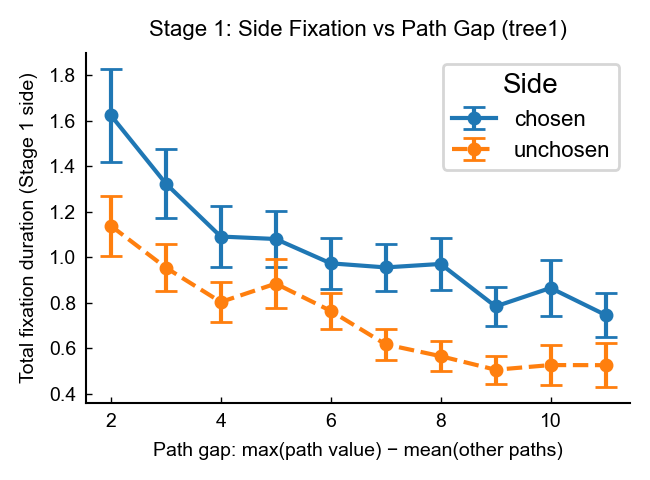

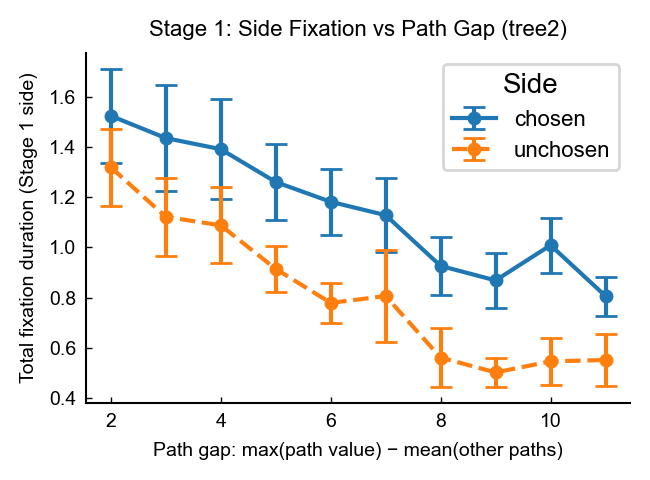

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

def plot_stage1_side_fixation_vs_path_gap(res: pd.DataFrame):
    """
    For Stage 1 only, split by tree_type ('tree1','tree2'):

    X-axis:
        gap = max(path value) - mean(other path values)
        Path values:
          tree1: L+LL, L+LR, R+RL
          tree2: L+LL, L+LR, R+RL, R+RR
        Path value = sum of rewards on nodes in that path.

    Y-axis:
        total fixation duration (Stage 1) across all nodes in the side
        (chosen side = 'chosen', other side = 'unchosen').

    Color/legend:
        'chosen' vs 'unchosen' (based on Stage-1 choice on L/R).
    """
    needed = {'wid','trial_index','tree_type','stage','node_identity','reward','fixation_duration','choice'}
    missing = needed - set(res.columns)
    if missing:
        raise ValueError(f"`res` missing required columns: {missing}")

    df = res.copy()
    df['reward'] = pd.to_numeric(df['reward'], errors='coerce')
    df['node_identity'] = df['node_identity'].astype(str)

    def _sem(x):
        n = x.count()
        return 0.0 if n <= 1 else float(x.std(ddof=1) / math.sqrt(n))

    trial_rows = []
    group_keys = ['wid','trial_index','tree_type']

    for (wid, tid, ttype), g in df.groupby(group_keys):
        # Stage 1 data
        g1 = g[g['stage'] == 1]
        ch = g1[(g1['node_identity'].isin(['L','R'])) & (g1['choice'] == 1)]
        if ch.empty:
            continue
        chosen_side = ch['node_identity'].iloc[0]
        unchosen_side = 'R' if chosen_side == 'L' else 'L'

        # reward map
        rmap = (g.dropna(subset=['node_identity'])
                  .drop_duplicates(subset=['node_identity'])
                  .set_index('node_identity')['reward']
                  .to_dict())

        # fixation map (stage 1 only)
        fmap = g1.groupby('node_identity')['fixation_duration'].sum().to_dict()

        # define paths
        if ttype == 'tree1':
            paths = {
                'L+LL': ['L','LL'],
                'L+LR': ['L','LR'],
                'R+RL': ['R','RL'],
            }
            L_side_all = {'L','LL','LR'}
            R_side_all = {'R','RL'}
        elif ttype == 'tree2':
            paths = {
                'L+LL': ['L','LL'],
                'L+LR': ['L','LR'],
                'R+RL': ['R','RL'],
                'R+RR': ['R','RR'],
            }
            L_side_all = {'L','LL','LR'}
            R_side_all = {'R','RL','RR'}
        else:
            continue

        def rv(idt):
            v = rmap.get(idt, np.nan)
            return 0.0 if pd.isna(v) else float(v)

        # path values
        path_vals = {p: sum(rv(i) for i in ids) for p, ids in paths.items()}
        max_val = max(path_vals.values())
        others = [v for v in path_vals.values() if v != max_val]
        if not others:
            continue
        gap = max_val - (sum(others) / len(others))

        # side sets
        chosen_set = L_side_all if chosen_side == 'L' else R_side_all
        unchosen_set = R_side_all if chosen_side == 'L' else L_side_all

        def fsum(ids):
            return float(sum(fmap.get(i, 0.0) for i in ids))

        trial_rows.append({
            'wid': wid, 'tree_type': ttype, 'gap': gap,
            'flag': 'chosen', 'fix_sum': fsum(chosen_set)
        })
        trial_rows.append({
            'wid': wid, 'tree_type': ttype, 'gap': gap,
            'flag': 'unchosen', 'fix_sum': fsum(unchosen_set)
        })

    if not trial_rows:
        raise RuntimeError("No valid trials found.")

    df_trial = pd.DataFrame(trial_rows)

    # per participant average
    df_wid = (df_trial.groupby(['wid','tree_type','gap','flag'])['fix_sum']
              .mean().reset_index(name='fix_mean'))

    # group stats
    group_stats = (df_wid.groupby(['tree_type','gap','flag'])['fix_mean']
                   .agg(mean='mean', sem=_sem).reset_index())

    # plot
    for ttype in ['tree1','tree2']:
        sub = group_stats[group_stats['tree_type'] == ttype]
        if sub.empty:
            continue
        gaps_sorted = np.sort(sub['gap'].unique())
        fig, ax = plt.subplots(figsize=(3.35, 2.5))
        for flag, style in zip(['chosen','unchosen'], ['o-','o--']):
            s = sub[sub['flag'] == flag].set_index('gap').reindex(gaps_sorted)
            ax.errorbar(
                s.index, s['mean'], yerr=s['sem'],
                fmt=style, label=flag, capsize=4, markersize=4
            )
        ax.set_xlabel('Path gap: max(path value) − mean(other paths)')
        ax.set_ylabel('Total fixation duration (Stage 1 side)')
        ax.set_title(f'Stage 1: Side Fixation vs Path Gap ({ttype})')
        ax.legend(title='Side', fontsize=8)
        ax.margins(x=0.05)
        plt.tight_layout()
        plt.show()

plot_stage1_side_fixation_vs_path_gap(res)

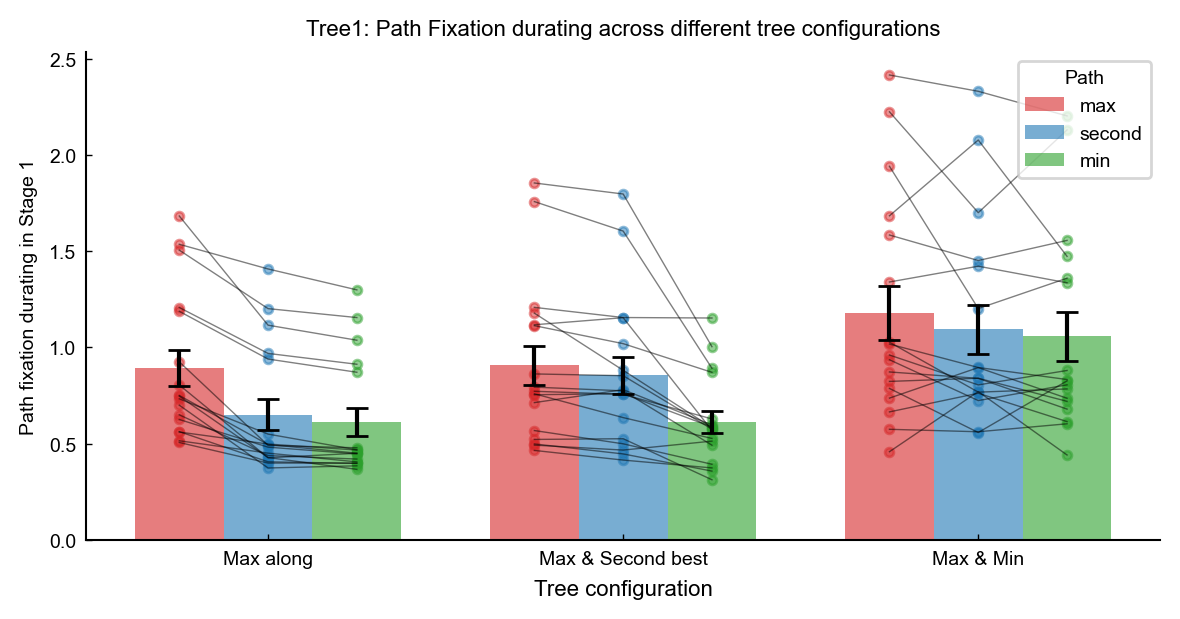

In [12]:
def plot_tree1_cases_stage1_path_fixation_with_points(res: pd.DataFrame):

    needed = {'wid','trial_index','tree_type','stage','node_identity','reward','fixation_duration'}
    missing = needed - set(res.columns)
    if missing:
        raise ValueError(f"`res` 缺少必要列: {missing}")

    df = res[(res['tree_type'] == 'tree1') & (res['stage'] == 1)].copy()
    if df.empty:
        raise RuntimeError("没有 tree1 的 Stage 1 数据。")

    df['node_identity'] = df['node_identity'].astype(object)
    df['reward'] = pd.to_numeric(df['reward'], errors='coerce')

    def _sem(x: pd.Series) -> float:
        n = x.count()
        return 0.0 if n <= 1 else float(x.std(ddof=1) / math.sqrt(n))

    PATHS = {
        'L+LL': ['L','LL'],
        'L+LR': ['L','LR'],
        'R+RL': ['R','RL'],
    }
    LEFT_PATHS = {'L+LL','L+LR'}
    RIGHT_PATH = 'R+RL'

    rows = []
    for (wid, tid), g in df.groupby(['wid','trial_index']):
        rmap = (g.dropna(subset=['node_identity'])
                 .drop_duplicates(subset=['node_identity'])
                 .set_index('node_identity')['reward']
                 .to_dict())
        def rv(idt):
            v = rmap.get(idt, np.nan)
            return 0.0 if pd.isna(v) else float(v)

        path_values = {pname: sum(rv(n) for n in nodes) for pname, nodes in PATHS.items()}
        vals = list(path_values.values())
        if len(set(np.round(vals, 12))) < 3:
            continue

        order = sorted(path_values.items(), key=lambda x: x[1], reverse=True)
        max_name, max_val = order[0]
        second_name, second_val = order[1]
        min_name, min_val = order[2]

        if max_name == RIGHT_PATH:
            case = "Max along"
        elif max_name in LEFT_PATHS and second_name in LEFT_PATHS:
            case = "Max & Second best"
        elif max_name in LEFT_PATHS and min_name in LEFT_PATHS:
            case = "Max & Min"
        else:
            continue

        fmap = g.groupby('node_identity', observed=True)['fixation_duration'].sum().to_dict()
        def fsum(nodes):
            return float(sum(fmap.get(n, 0.0) for n in nodes))

        path_fix = {pname: fsum(nodes) for pname, nodes in PATHS.items()}

        rows.append({'wid': wid, 'case': case, 'role': 'max',    'fix': path_fix.get(max_name, 0.0)})
        rows.append({'wid': wid, 'case': case, 'role': 'second', 'fix': path_fix.get(second_name, 0.0)})
        rows.append({'wid': wid, 'case': case, 'role': 'min',    'fix': path_fix.get(min_name, 0.0)})

    if not rows:
        raise RuntimeError("没有可绘图的 trial。")

    df_trials = pd.DataFrame(rows)
    df_wid = (df_trials.groupby(['wid','case','role'], observed=True)['fix']
                        .mean().reset_index())

    stats = (df_wid.groupby(['case','role'], observed=True)['fix']
                  .agg(mean='mean', sem=_sem)
                  .reset_index())

    case_order = ["Max along", "Max & Second best", "Max & Min"]
    role_order = ['max','second','min']
    width = 0.25
    present_cases = [c for c in case_order if c in set(stats['case'])]
    x = np.arange(len(present_cases))

    # 固定颜色映射
    role_colors = {
        'max':    '#d62728',  # red
        'second': '#1f77b4',  # blue
        'min':    '#2ca02c',  # green
    }

    fig, ax = plt.subplots(figsize=(6, 3.2))

    # --- 绘制 group bar + SEM ---
    for i, role in enumerate(role_order):
        sub = stats[(stats['role'] == role) & (stats['case'].isin(present_cases))].set_index('case')
        heights = [sub.loc[c, 'mean'] if c in sub.index else 0.0 for c in present_cases]
        errs    = [sub.loc[c, 'sem']  if c in sub.index else 0.0 for c in present_cases]
        ax.bar(x + (i - 1)*width, heights, width, yerr=errs,
               capsize=4, label=role, alpha=0.6, color=role_colors[role])

    # --- 绘制每个被试的散点 & 连接线 ---
    for wid, g in df_wid.groupby('wid'):
        for idx_case, case in enumerate(present_cases):
            sub = g[g['case'] == case].set_index('role')
            if not set(role_order).issubset(sub.index):
                continue
            y_vals = [sub.loc[role, 'fix'] for role in role_order]
            x_vals = [idx_case + (i - 1)*width for i in range(len(role_order))]
            # 黑线
            ax.plot(x_vals, y_vals, color='black', linewidth=0.5, alpha=0.5)
            # 颜色与bar一致但透明度低
            for xv, yv, role in zip(x_vals, y_vals, role_order):
                ax.scatter(xv, yv, color=role_colors[role], s=10, alpha=0.5)

    ax.set_xticks(x)
    # set the x title as tree configuration
    ax.set_xlabel('Tree configuration', fontsize=8)
    ax.set_xticklabels(present_cases, rotation=0)
    ax.set_ylabel('Path fixation durating in Stage 1')
    ax.set_title('Tree1: Path Fixation durating across different tree configurations')
    ax.legend(title='Path', fontsize=7, title_fontsize=7)
    ax.margins(x=0.05)
    plt.tight_layout()
    plt.show()

plot_tree1_cases_stage1_path_fixation_with_points(res)

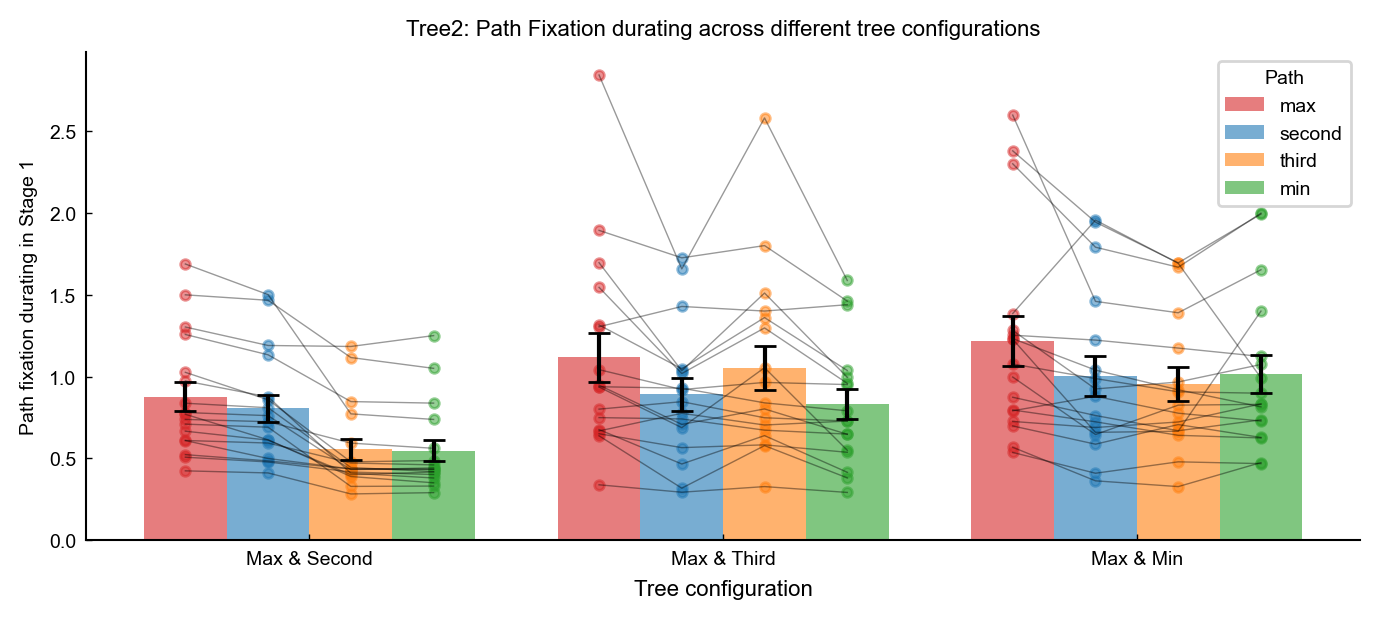

In [13]:
def plot_tree2_cases_stage1_path_fixation_with_points(res: pd.DataFrame):
    """
    Tree2 专用：三类情形按“与 max path 同侧的兄弟路径”的全局排名来划分：
        Cases: "Max & Second" / "Max & Third" / "Max & Min"
    路径（tree2）：L+LL, L+LR, R+RL, R+RR
    Y轴：Stage 1 路径注视时长（该路径两个节点在 Stage1 的 fixation_duration 之和）
    图：分组柱（±SEM）+ 个体散点（与柱同色、透明度低）+ 个体细黑连线
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import math

    needed = {'wid','trial_index','tree_type','stage','node_identity','reward','fixation_duration'}
    missing = needed - set(res.columns)
    if missing:
        raise ValueError(f"`res` is missing required columns: {missing}")

    # 仅 tree2 且 Stage1（fixation 用）
    df = res[(res['tree_type'] == 'tree2') & (res['stage'] == 1)].copy()
    if df.empty:
        raise RuntimeError("No Stage 1 data for tree2.")

    df['node_identity'] = df['node_identity'].astype(object)
    df['reward'] = pd.to_numeric(df['reward'], errors='coerce')

    def _sem(x: pd.Series) -> float:
        n = x.count()
        return 0.0 if n <= 1 else float(x.std(ddof=1) / math.sqrt(n))

    # 路径定义与“侧别”
    PATHS = {
        'L+LL': ['L','LL'],
        'L+LR': ['L','LR'],
        'R+RL': ['R','RL'],
        'R+RR': ['R','RR'],
    }
    PATH_SIDE = {
        'L+LL': 'L', 'L+LR': 'L',
        'R+RL': 'R', 'R+RR': 'R'
    }

    rows = []
    for (wid, tid), g in df.groupby(['wid','trial_index']):
        # 奖励映射（node_identity -> reward）
        rmap = (g.dropna(subset=['node_identity'])
                 .drop_duplicates(subset=['node_identity'])
                 .set_index('node_identity')['reward']
                 .to_dict())

        def rv(idt):
            v = rmap.get(idt, np.nan)
            return 0.0 if pd.isna(v) else float(v)

        # 路径价值
        path_vals = {p: sum(rv(n) for n in nodes) for p, nodes in PATHS.items()}

        # 跳过并列（避免 rank 歧义；如需破同分可改成加入微小扰动或固定优先级）
        vals = np.array(list(path_vals.values()), dtype=float)
        if len(set(np.round(vals, 12))) < 4:
            continue

        # 全局排序（降序）
        order = sorted(path_vals.items(), key=lambda x: x[1], reverse=True)
        max_name, _     = order[0]
        second_name, _  = order[1]
        third_name, _   = order[2]
        min_name, _     = order[3]

        # 与 max 同侧的“兄弟路径”
        max_side = PATH_SIDE[max_name]
        sibling = None
        for p in PATHS:
            if p != max_name and PATH_SIDE[p] == max_side:
                sibling = p
                break
        if sibling is None:
            continue  # 理论上不会发生

        # 兄弟路径在全局排序中的“角色”
        role_rank = {order[0][0]:'max', order[1][0]:'second', order[2][0]:'third', order[3][0]:'min'}
        sibling_role = role_rank[sibling]
        if sibling_role == 'second':
            case_label = "Max & Second"
        elif sibling_role == 'third':
            case_label = "Max & Third"
        else:
            case_label = "Max & Min"

        # Stage1 路径注视时长（两个节点之和）
        fmap = g.groupby('node_identity', observed=True)['fixation_duration'].sum().to_dict()
        def fsum(nodes):
            return float(sum(fmap.get(n, 0.0) for n in nodes))
        path_fix = {p: fsum(nodes) for p, nodes in PATHS.items()}

        # 只为这个 trial 的“唯一 case”写入四个角色的值
        role_to_path = {
            'max'   : max_name,
            'second': second_name,
            'third' : third_name,
            'min'   : min_name,
        }
        for role, pname in role_to_path.items():
            rows.append({
                'wid': wid,
                'trial_index': tid,
                'case': case_label,
                'role': role,
                'fix': path_fix.get(pname, 0.0)
            })

    if not rows:
        raise RuntimeError("No eligible trials to plot (ties or no valid classification).")

    df_trials = pd.DataFrame(rows)

    # 被试内平均 (wid, case, role)
    df_wid = (df_trials.groupby(['wid','case','role'], observed=True)['fix']
                        .mean().reset_index())

    # 群体均值 ± SEM
    stats = (df_wid.groupby(['case','role'], observed=True)['fix']
                  .agg(mean='mean', sem=_sem)
                  .reset_index())

    # 绘图
    case_order = ["Max & Second", "Max & Third", "Max & Min"]
    role_order = ['max','second','third','min']
    width = 0.20

    present_cases = [c for c in case_order if c in set(stats['case'])]
    x = np.arange(len(present_cases))

    # 统一颜色；散点复用相同颜色但更低透明度
    role_colors = {
        'max':    '#d62728',  # red
        'second': '#1f77b4',  # blue
        'third':  '#ff7f0e',  # orange
        'min':    '#2ca02c',  # green
    }

    fig, ax = plt.subplots(figsize=(7.0, 3.2))

    # Bars with SEM
    for i, role in enumerate(role_order):
        sub = stats[(stats['role'] == role) & (stats['case'].isin(present_cases))].set_index('case')
        heights = [sub.loc[c, 'mean'] if c in sub.index else 0.0 for c in present_cases]
        errs    = [sub.loc[c, 'sem']  if c in sub.index else 0.0 for c in present_cases]
        ax.bar(x + (i - (len(role_order)-1)/2)*width, heights, width,
               yerr=errs, capsize=4, label=role, alpha=0.6, color=role_colors[role])

    # Individual points + thin black lines
    for wid, g in df_wid.groupby('wid'):
        for idx_case, case in enumerate(present_cases):
            sub = g[g['case'] == case].set_index('role')
            if not set(role_order).issubset(sub.index):
                continue
            y_vals = [sub.loc[role, 'fix'] for role in role_order]
            x_vals = [idx_case + (i - (len(role_order)-1)/2)*width for i in range(len(role_order))]
            ax.plot(x_vals, y_vals, color='black', linewidth=0.5, alpha=0.4)
            for xv, yv, role in zip(x_vals, y_vals, role_order):
                ax.scatter(xv, yv, color=role_colors[role], s=12, alpha=0.5)

    ax.set_xticks(x)
    ax.set_xticklabels(present_cases, rotation=0, fontsize=7)
    ax.set_xlabel('Tree configuration', fontsize=8)
    ax.set_ylabel('Path fixation durating in Stage 1')
    ax.set_title('Tree2: Path Fixation durating across different tree configurations')
    ax.legend(title='Path', fontsize=7, title_fontsize=7)
    ax.margins(x=0.05)
    plt.tight_layout()
    plt.show()

plot_tree2_cases_stage1_path_fixation_with_points(res)

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

def _sem(x: pd.Series) -> float:
    n = x.count()
    return 0.0 if n <= 1 else float(x.std(ddof=1) / math.sqrt(n))

def _plot_first_vs_second_series(df_wid_stats, title):
    # Build 4 curves: chosen_first, chosen_second_mean, unchosen_first, unchosen_second_mean
    side_order   = ['chosen', 'unchosen']
    series_order = ['first', 'second_mean']
    style_map = {
        ('chosen','first'):       dict(fmt='o-',  markersize=4, label='Chosen — first'),
        ('chosen','second_mean'): dict(fmt='s-',  markersize=4, label='Chosen — second mean'),
        ('unchosen','first'):     dict(fmt='o--', markersize=4, label='Unchosen — first'),
        ('unchosen','second_mean'):dict(fmt='s--', markersize=4, label='Unchosen — second mean'),
    }

    gaps_sorted = np.sort(df_wid_stats['gap'].unique())
    fig, ax = plt.subplots(figsize=(4.2, 2.8))

    for side in side_order:
        for series in series_order:
            sub = (df_wid_stats[(df_wid_stats['side']==side) &
                                 (df_wid_stats['series']==series)]
                   .set_index('gap').reindex(gaps_sorted))
            if sub.empty:
                continue
            ax.errorbar(
                sub.index.to_numpy(),
                sub['mean'].to_numpy(),
                yerr=sub['sem'].to_numpy(),
                capsize=4,
                **style_map[(side, series)]
            )

    ax.axvline(0, linestyle='--', linewidth=1)
    ax.set_xlabel('First − mean(Second) on side (reward)')
    ax.set_ylabel('Fixation duration (Stage 1)')
    ax.set_title(title)
    ax.legend(fontsize=8, title='Series', title_fontsize=8, ncols=2)
    ax.margins(x=0.05)
    plt.tight_layout()
    plt.show()


def plot_stage1_first_vs_second_fix_tree1(res: pd.DataFrame):
    """
    Tree1 only.
    X = reward(first-layer) − mean(reward(second-layer on that side))
    Y = fixation duration (Stage 1), two curves per side:
        - first-layer node
        - mean of second-layer nodes
    Sides: chosen & unchosen (determined by Stage-1 choice among L/R).
    """
    needed = {'wid','trial_index','tree_type','stage','node_identity','reward','fixation_duration','choice'}
    miss = needed - set(res.columns)
    if miss:
        raise ValueError(f"`res` missing: {miss}")

    # Stage 1 rows for fixation; rewards taken per trial (static)
    df_all = res.copy()
    df_all['reward'] = pd.to_numeric(df_all['reward'], errors='coerce')
    df_all['node_identity'] = df_all['node_identity'].astype(object)

    df = df_all[(df_all['tree_type']=='tree1') & (df_all['stage']==1)].copy()
    if df.empty:
        raise RuntimeError("No Stage 1 rows for tree1.")

    rows = []
    for (wid, tid), g1 in df.groupby(['wid','trial_index']):
        # Determine chosen side at Stage 1
        ch = g1[(g1['node_identity'].isin(['L','R'])) & (g1['choice']==1)]
        if ch.empty:
            continue
        chosen = ch['node_identity'].iloc[0]   # 'L' or 'R'
        unchosen = 'R' if chosen=='L' else 'L'

        # Rewards map from this trial (any stage)
        gtrial = df_all[(df_all['wid']==wid) & (df_all['trial_index']==tid)]
        rmap = (gtrial.dropna(subset=['node_identity'])
                      .drop_duplicates(subset=['node_identity'])
                      .set_index('node_identity')['reward']
                      .to_dict())
        def rv(idt):
            v = rmap.get(idt, np.nan)
            return 0.0 if pd.isna(v) else float(v)

        # Stage 1 fixation map
        f1 = g1.groupby('node_identity', observed=True)['fixation_duration'].sum().to_dict()
        def fsum(ids):
            return float(sum(f1.get(i, 0.0) for i in ids))
        def fmean(ids):
            ids = list(ids)
            return fsum(ids)/len(ids) if ids else 0.0

        # Tree1 leaves
        left_second  = {'LL','LR'}
        right_second = {'RL'}  # single leaf

        # Helper to emit both sides
        def add_side(side):
            if side=='L':
                first = 'L'
                seconds = left_second
            else:
                first = 'R'
                seconds = right_second
            # x: reward gap on this side
            x_gap = rv(first) - (np.mean([rv(s) for s in seconds]) if seconds else 0.0)
            # y: fixation durations (first vs mean(seconds))
            y_first = f1.get(first, 0.0)
            y_second_mean = np.mean([f1.get(s, 0.0) for s in seconds]) if seconds else 0.0
            rows.append({'wid': wid, 'side':'chosen' if side==chosen else 'unchosen',
                         'gap': x_gap, 'series':'first', 'y': y_first})
            rows.append({'wid': wid, 'side':'chosen' if side==chosen else 'unchosen',
                         'gap': x_gap, 'series':'second_mean', 'y': y_second_mean})

        add_side('L'); add_side('R')

    if not rows:
        raise RuntimeError("No valid trials (tree1) with Stage-1 choice on L/R.")

    df_trial = pd.DataFrame(rows)

    # Participant mean over trials per (wid, side, gap, series)
    df_wid = (df_trial.groupby(['wid','side','gap','series'], observed=True)['y']
              .mean().reset_index(name='y_mean'))

    # Group mean ± SEM
    df_stats = (df_wid.groupby(['side','gap','series'], observed=True)['y_mean']
                .agg(mean='mean', sem=_sem).reset_index())

    _plot_first_vs_second_series(df_stats, title='Tree1 — Stage 1: First vs Second-layer fixation')


def plot_stage1_first_vs_second_fix_tree2(res: pd.DataFrame):
    """
    Tree2 only.
    X = reward(first-layer) − mean(reward(second-layer on that side))
    Y = fixation duration (Stage 1), two curves per side:
        - first-layer node
        - mean of second-layer nodes
    Sides: chosen & unchosen (determined by Stage-1 choice among L/R).
    """
    needed = {'wid','trial_index','tree_type','stage','node_identity','reward','fixation_duration','choice'}
    miss = needed - set(res.columns)
    if miss:
        raise ValueError(f"`res` missing: {miss}")

    df_all = res.copy()
    df_all['reward'] = pd.to_numeric(df_all['reward'], errors='coerce')
    df_all['node_identity'] = df_all['node_identity'].astype(object)

    df = df_all[(df_all['tree_type']=='tree2') & (df_all['stage']==1)].copy()
    if df.empty:
        raise RuntimeError("No Stage 1 rows for tree2.")

    rows = []
    for (wid, tid), g1 in df.groupby(['wid','trial_index']):
        # chosen side
        ch = g1[(g1['node_identity'].isin(['L','R'])) & (g1['choice']==1)]
        if ch.empty:
            continue
        chosen = ch['node_identity'].iloc[0]
        unchosen = 'R' if chosen=='L' else 'L'

        # rewards map from trial (any stage)
        gtrial = df_all[(df_all['wid']==wid) & (df_all['trial_index']==tid)]
        rmap = (gtrial.dropna(subset=['node_identity'])
                      .drop_duplicates(subset=['node_identity'])
                      .set_index('node_identity')['reward']
                      .to_dict())
        def rv(idt):
            v = rmap.get(idt, np.nan)
            return 0.0 if pd.isna(v) else float(v)

        # Stage 1 fixation map
        f1 = g1.groupby('node_identity', observed=True)['fixation_duration'].sum().to_dict()

        def fsum(ids):
            return float(sum(f1.get(i, 0.0) for i in ids))
        def fmean(ids):
            ids = list(ids)
            return fsum(ids)/len(ids) if ids else 0.0

        # Tree2 leaves
        left_second  = {'LL','LR'}
        right_second = {'RL','RR'}

        def add_side(side):
            if side=='L':
                first = 'L'
                seconds = left_second
            else:
                first = 'R'
                seconds = right_second
            x_gap = rv(first) - (np.mean([rv(s) for s in seconds]) if seconds else 0.0)
            y_first = f1.get(first, 0.0)
            y_second_mean = np.mean([f1.get(s, 0.0) for s in seconds]) if seconds else 0.0
            rows.append({'wid': wid, 'side':'chosen' if side==chosen else 'unchosen',
                         'gap': x_gap, 'series':'first', 'y': y_first})
            rows.append({'wid': wid, 'side':'chosen' if side==chosen else 'unchosen',
                         'gap': x_gap, 'series':'second_mean', 'y': y_second_mean})

        add_side('L'); add_side('R')

    if not rows:
        raise RuntimeError("No valid trials (tree2) with Stage-1 choice on L/R.")

    df_trial = pd.DataFrame(rows)
    df_wid = (df_trial.groupby(['wid','side','gap','series'], observed=True)['y']
              .mean().reset_index(name='y_mean'))
    df_stats = (df_wid.groupby(['side','gap','series'], observed=True)['y_mean']
                .agg(mean='mean', sem=_sem).reset_index())

    _plot_first_vs_second_series(df_stats, title='Tree2 — Stage 1: First vs Second-layer fixation')


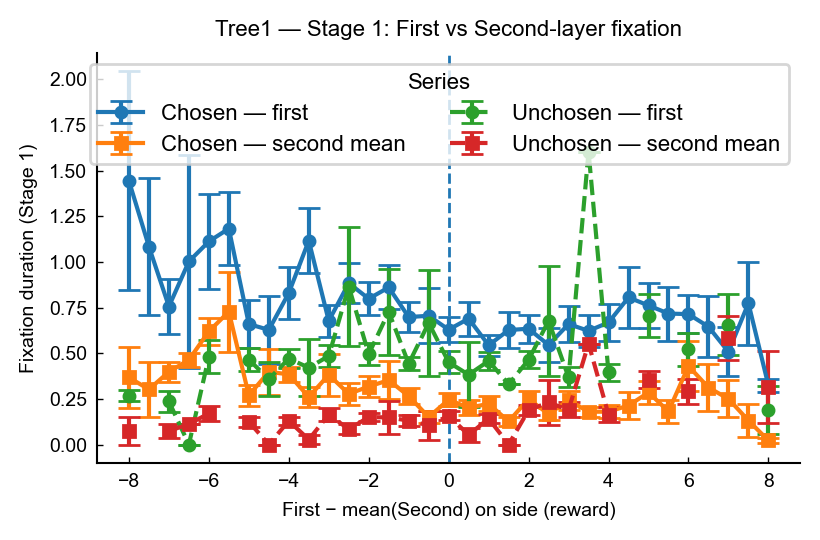

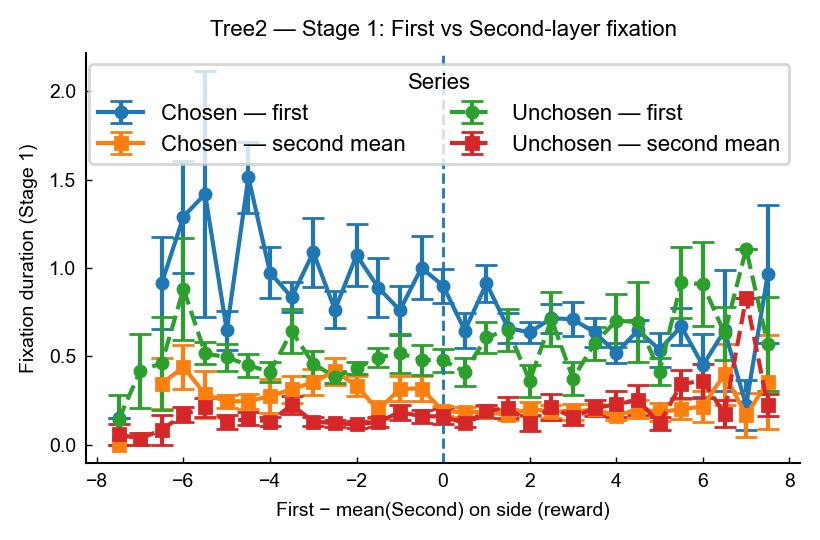

In [50]:
# Tree 1
plot_stage1_first_vs_second_fix_tree1(res)

# Tree 2
plot_stage1_first_vs_second_fix_tree2(res)

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# ---------- helpers ----------
def _sem(x: pd.Series) -> float:
    n = x.count()
    return 0.0 if n <= 1 else float(x.std(ddof=1) / math.sqrt(n))

def _plot_bars_with_points(df_stats: pd.DataFrame, df_wid: pd.DataFrame, title: str):
    """
    df_stats: group means/SEMs with columns ['sign','series_side','mean','sem']
    df_wid  : per-participant means with columns ['wid','sign','series_side','y_mean']
    Plots grouped bars for two signs (Positive, Negative) and four series per sign,
    overlays each participant as scatter (same color as bar, lower alpha),
    and connects a participant's four points within each sign using a thin black line.
    """
    # x groups (two signs) and series order (four bars per group)
    sign_order   = ['Positive', 'Negative']
    series_order = ['chosen_first','chosen_second_mean','unchosen_first','unchosen_second_mean']

    # Sort/categorize
    df_stats = df_stats.copy()
    df_stats['sign'] = pd.Categorical(df_stats['sign'], categories=sign_order, ordered=True)
    df_stats['series_side'] = pd.Categorical(df_stats['series_side'], categories=series_order, ordered=True)
    df_stats = df_stats.sort_values(['sign','series_side'])

    df_wid = df_wid.copy()
    df_wid['sign'] = pd.Categorical(df_wid['sign'], categories=sign_order, ordered=True)
    df_wid['series_side'] = pd.Categorical(df_wid['series_side'], categories=series_order, ordered=True)

    # Colors consistent across plots
    colors = {
        'chosen_first': '#d62728',        # red
        'chosen_second_mean': '#ff7f0e',  # orange
        'unchosen_first': '#1f77b4',      # blue
        'unchosen_second_mean': '#2ca02c' # green
    }

    # X positions
    x_groups = np.arange(len(sign_order))
    width = 0.20

    fig, ax = plt.subplots(figsize=(6.2, 3.2))

    # Bars + SEM
    for i, sname in enumerate(series_order):
        sub = df_stats[df_stats['series_side']==sname].set_index('sign')
        heights = [float(sub.loc[sg,'mean']) if sg in sub.index else 0.0 for sg in sign_order]
        errs    = [float(sub.loc[sg,'sem'])  if sg in sub.index else 0.0 for sg in sign_order]
        xpos = x_groups + (i - (len(series_order)-1)/2)*width
        ax.bar(xpos, heights, width, yerr=errs, capsize=4,
               color=colors[sname], alpha=0.8, label=sname, zorder=2)

    # Overlay per-participant scatter and within-sign connecting lines
    # Precompute bar centers per sign×series for alignment
    bar_centers = {
        (sign, sname): float(x_groups[j] + (i - (len(series_order)-1)/2)*width)
        for j, sign in enumerate(sign_order)
        for i, sname in enumerate(series_order)
    }

    for wid, g in df_wid.groupby('wid'):
        # for each sign (Positive/Negative), connect the four series points
        for j, sign in enumerate(sign_order):
            sub = g[g['sign'] == sign].set_index('series_side')
            if not set(series_order).issubset(sub.index):
                continue
            xs = [bar_centers[(sign, sname)] for sname in series_order]
            ys = [float(sub.loc[sname, 'y_mean']) for sname in series_order]
            # thin black connecting line
            ax.plot(xs, ys, color='black', linewidth=0.5, alpha=0.5, zorder=3)
            # scatter (same color as bars, lower alpha)
            for sname, xv, yv in zip(series_order, xs, ys):
                ax.scatter(xv, yv, color=colors[sname], s=14, alpha=0.55, zorder=4)

    ax.set_xticks(x_groups)
    ax.set_xticklabels(sign_order)
    ax.set_xlabel('Sign of [mean(first-layer rewards) − mean(second-layer rewards)] (trial-level)')
    ax.set_ylabel('Fixation duration (Stage 1)')
    ax.set_title(title)
    ax.legend(title='Categories', fontsize=7, title_fontsize=7)
    ax.margins(x=0.05)
    plt.tight_layout()
    plt.show()


# ---------- TREE 1 ----------
def plot_stage1_bar_sign_trial_mean_gap_tree1(res: pd.DataFrame):
    """
    Tree1 only.

    X-axis grouping (two bars groups by sign):
        gap_trial = mean(rewards on {'L','R'}) − mean(rewards on {'LL','LR','RL'})
        sign = Positive if gap_trial >= 0 else Negative
        (Single trial-level sign shared by chosen and unchosen sides.)

    Bars (four series per sign; mean ± SEM across participants):
        - chosen_first         : Stage-1 fixation of first-layer node on chosen side (L or R)
        - chosen_second_mean   : Stage-1 mean fixation across second-layer nodes on chosen side
        - unchosen_first       : Stage-1 fixation of first-layer node on unchosen side
        - unchosen_second_mean : Stage-1 mean fixation across second-layer nodes on unchosen side

    Also overlays per-participant scatter points (same color as bars, lower alpha)
    and connects the four series within each sign by a thin black line.
    """
    needed = {'wid','trial_index','tree_type','stage','node_identity','reward','fixation_duration','choice'}
    miss = needed - set(res.columns)
    if miss:
        raise ValueError(f"`res` missing: {miss}")

    df_all = res.copy()
    df_all['reward'] = pd.to_numeric(df_all['reward'], errors='coerce')
    df_all['node_identity'] = df_all['node_identity'].astype(object)

    df = df_all[(df_all['tree_type']=='tree1') & (df_all['stage']==1)].copy()
    if df.empty:
        raise RuntimeError("No Stage 1 rows for tree1.")

    rows = []
    for (wid, tid), g1 in df.groupby(['wid','trial_index']):
        # Stage-1 L/R choice
        ch = g1[(g1['node_identity'].isin(['L','R'])) & (g1['choice']==1)]
        if ch.empty:
            continue
        chosen = ch['node_identity'].iloc[0]
        unchosen = 'R' if chosen=='L' else 'L'

        # rewards map from the trial (any stage)
        gtrial = df_all[(df_all['wid']==wid) & (df_all['trial_index']==tid)]
        rmap = (gtrial.dropna(subset=['node_identity'])
                      .drop_duplicates(subset=['node_identity'])
                      .set_index('node_identity')['reward']
                      .to_dict())
        def rv(idt):
            v = rmap.get(idt, np.nan)
            return 0.0 if pd.isna(v) else float(v)

        # trial-level mean gap: mean(first-layer) − mean(second-layer)
        first_nodes  = ['L','R']
        second_nodes = ['LL','LR','RL']  # tree1 leaves
        gap_trial = np.mean([rv(x) for x in first_nodes]) - np.mean([rv(x) for x in second_nodes])
        sign_label = 'Positive' if gap_trial >= 0 else 'Negative'

        # Stage-1 fixation map
        f1 = g1.groupby('node_identity', observed=True)['fixation_duration'].sum().to_dict()
        left_seconds  = ['LL','LR']
        right_seconds = ['RL']

        def y_first(side):
            return f1.get(side, 0.0)

        def y_second_mean(side):
            secs = left_seconds if side=='L' else right_seconds
            return float(np.mean([f1.get(s, 0.0) for s in secs])) if len(secs) else 0.0

        rows.extend([
            {'wid': wid, 'sign': sign_label, 'series_side': 'chosen_first',         'y': y_first(chosen)},
            {'wid': wid, 'sign': sign_label, 'series_side': 'chosen_second_mean',   'y': y_second_mean(chosen)},
            {'wid': wid, 'sign': sign_label, 'series_side': 'unchosen_first',       'y': y_first(unchosen)},
            {'wid': wid, 'sign': sign_label, 'series_side': 'unchosen_second_mean', 'y': y_second_mean(unchosen)},
        ])

    if not rows:
        raise RuntimeError("No eligible trials for tree1 (check Stage-1 choices and rewards).")

    df_trial = pd.DataFrame(rows)

    # Per-participant mean within sign × series
    df_wid = (df_trial.groupby(['wid','sign','series_side'], observed=True)['y']
              .mean().reset_index(name='y_mean'))

    # Group mean ± SEM across participants
    df_stats = (df_wid.groupby(['sign','series_side'], observed=True)['y_mean']
                .agg(mean='mean', sem=_sem).reset_index())

    _plot_bars_with_points(df_stats, df_wid, title='Tree1 — Stage 1 fixation by sign of trial-mean gap')


# ---------- TREE 2 ----------
def plot_stage1_bar_sign_trial_mean_gap_tree2(res: pd.DataFrame):
    """
    Tree2 only.

    X-axis grouping (two bars groups by sign):
        gap_trial = mean(rewards on {'L','R'}) − mean(rewards on {'LL','LR','RL','RR'})
        sign = Positive if gap_trial >= 0 else Negative

    Bars (four series per sign; mean ± SEM across participants) and
    per-participant scatter + within-sign connecting line (thin black).
    """
    needed = {'wid','trial_index','tree_type','stage','node_identity','reward','fixation_duration','choice'}
    miss = needed - set(res.columns)
    if miss:
        raise ValueError(f"`res` missing: {miss}")

    df_all = res.copy()
    df_all['reward'] = pd.to_numeric(df_all['reward'], errors='coerce')
    df_all['node_identity'] = df_all['node_identity'].astype(object)

    df = df_all[(df_all['tree_type']=='tree2') & (df_all['stage']==1)].copy()
    if df.empty:
        raise RuntimeError("No Stage 1 rows for tree2.")

    rows = []
    for (wid, tid), g1 in df.groupby(['wid','trial_index']):
        ch = g1[(g1['node_identity'].isin(['L','R'])) & (g1['choice']==1)]
        if ch.empty:
            continue
        chosen = ch['node_identity'].iloc[0]
        unchosen = 'R' if chosen=='L' else 'L'

        gtrial = df_all[(df_all['wid']==wid) & (df_all['trial_index']==tid)]
        rmap = (gtrial.dropna(subset=['node_identity'])
                      .drop_duplicates(subset=['node_identity'])
                      .set_index('node_identity')['reward']
                      .to_dict())
        def rv(idt):
            v = rmap.get(idt, np.nan)
            return 0.0 if pd.isna(v) else float(v)

        # trial-level mean gap
        first_nodes  = ['L','R']
        second_nodes = ['LL','LR','RL','RR']  # tree2 leaves
        gap_trial = np.mean([rv(x) for x in first_nodes]) - np.mean([rv(x) for x in second_nodes])
        sign_label = 'Positive' if gap_trial >= 0 else 'Negative'

        # Stage-1 fixation map
        f1 = g1.groupby('node_identity', observed=True)['fixation_duration'].sum().to_dict()
        left_seconds  = ['LL','LR']
        right_seconds = ['RL','RR']

        def y_first(side):
            return f1.get(side, 0.0)

        def y_second_mean(side):
            secs = left_seconds if side=='L' else right_seconds
            return float(np.mean([f1.get(s, 0.0) for s in secs])) if len(secs) else 0.0

        rows.extend([
            {'wid': wid, 'sign': sign_label, 'series_side': 'chosen_first',         'y': y_first(chosen)},
            {'wid': wid, 'sign': sign_label, 'series_side': 'chosen_second_mean',   'y': y_second_mean(chosen)},
            {'wid': wid, 'sign': sign_label, 'series_side': 'unchosen_first',       'y': y_first(unchosen)},
            {'wid': wid, 'sign': sign_label, 'series_side': 'unchosen_second_mean', 'y': y_second_mean(unchosen)},
        ])

    if not rows:
        raise RuntimeError("No eligible trials for tree2 (check Stage-1 choices and rewards).")

    df_trial = pd.DataFrame(rows)
    df_wid = (df_trial.groupby(['wid','sign','series_side'], observed=True)['y']
              .mean().reset_index(name='y_mean'))
    df_stats = (df_wid.groupby(['sign','series_side'], observed=True)['y_mean']
                .agg(mean='mean', sem=_sem).reset_index())

    _plot_bars_with_points(df_stats, df_wid, title='Tree2 — Stage 1 fixation by sign of trial-mean gap')

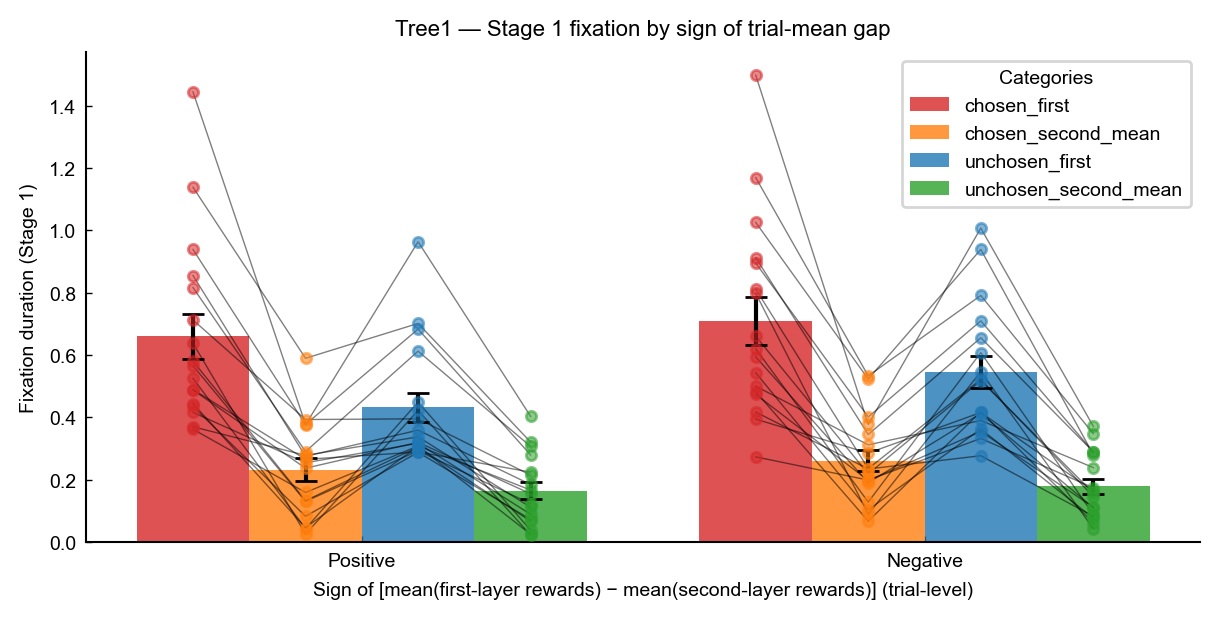

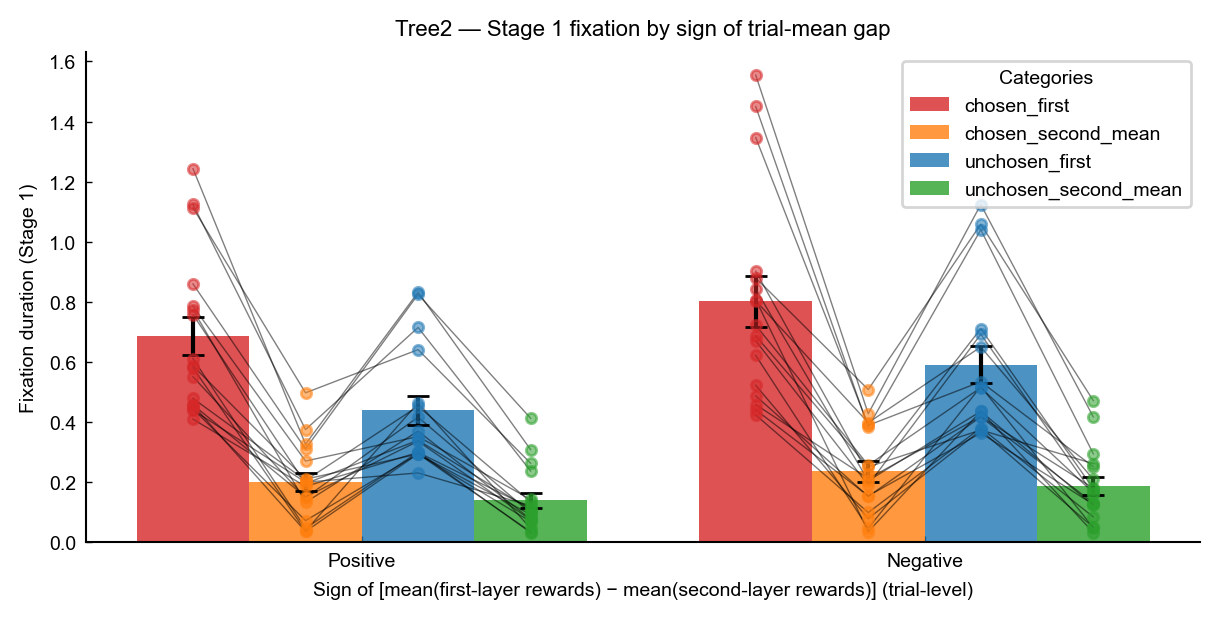

In [15]:
plot_stage1_bar_sign_trial_mean_gap_tree1(res)
plot_stage1_bar_sign_trial_mean_gap_tree2(res)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# ---------- helpers ----------
def _sem(x: pd.Series) -> float:
    n = x.count()
    return 0.0 if n <= 1 else float(x.std(ddof=1) / math.sqrt(n))

def _bin_gap_value_trial(gap: float):
    """
    Bin edges & labels (inclusive on right; lowest included on left):
      [-8, -4], (-4, 0], (0, 4], (4, 8]
    Return the string label, or None if outside [-8, 8] or NaN.
    """
    if pd.isna(gap) or gap < -8 or gap > 8:
        return None
    bins   = [-8, -4, 0, 4, 8]
    labels = ['[-8,-4]', '(-4,0]', '(0,4]', '(4,8]']
    # Handle exact 8 edge to keep in last bin
    gap_adj = 8 - 1e-12 if gap == 8 else gap
    return str(pd.cut([gap_adj], bins=bins, labels=labels, include_lowest=True, right=True)[0])

def _grouped_bar_by_bins(df_stats: pd.DataFrame, title: str):
    bin_order = ['[-8,-4]', '(-4,0]', '(0,4]', '(4,8]']
    series_order = ['chosen_first','chosen_second_mean','unchosen_first','unchosen_second_mean']

    df_stats = df_stats[df_stats['bin'].isin(bin_order)].copy()
    if df_stats.empty:
        raise RuntimeError("No data fell into the specified bins.")

    df_stats['bin'] = pd.Categorical(df_stats['bin'], categories=bin_order, ordered=True)
    df_stats['series_side'] = pd.Categorical(df_stats['series_side'], categories=series_order, ordered=True)

    colors = {
        'chosen_first': '#d62728',        # red
        'chosen_second_mean': '#ff7f0e',  # orange
        'unchosen_first': '#1f77b4',      # blue
        'unchosen_second_mean': '#2ca02c' # green
    }

    x = np.arange(len(bin_order))
    width = 0.2
    fig, ax = plt.subplots(figsize=(6.2, 3.2))

    for i, sname in enumerate(series_order):
        sub = df_stats[df_stats['series_side'] == sname].set_index('bin')
        heights = [float(sub.loc[b, 'mean']) if b in sub.index else 0.0 for b in bin_order]
        errs    = [float(sub.loc[b, 'sem'])  if b in sub.index else 0.0 for b in bin_order]
        ax.bar(x + (i - (len(series_order)-1)/2)*width,
               heights, width, yerr=errs, capsize=4,
               color=colors[sname], alpha=0.8, label=sname)

    ax.set_xticks(x)
    ax.set_xticklabels(bin_order)
    ax.set_xlabel('Binned trial gap: mean(first-layer rewards) − mean(second-layer rewards)')
    ax.set_ylabel('Fixation duration (Stage 1)')
    ax.set_title(title)
    ax.legend(title='Series', fontsize=8, title_fontsize=8, ncols=2)
    ax.margins(x=0.05)
    plt.tight_layout()
    plt.show()


# ---------- TREE 1 ----------
def plot_stage1_binned_trial_gap_mean_first_minus_second_tree1(res: pd.DataFrame):
    """
    Tree1 only.

    X-axis binning (trial-level, shared by both sides in the trial):
        gap_trial = mean( rewards on {'L','R'} ) − mean( rewards on {'LL','LR','RL'} )
        Then bin into: [-8,-4], (-4,0], (0,4], (4,8]

    Bars (four series per bin; mean ± SEM across participants):
        - chosen_first         : Stage-1 fixation of first-layer node on chosen side (L or R)
        - chosen_second_mean   : Stage-1 mean fixation across second-layer nodes on chosen side
        - unchosen_first       : Stage-1 fixation of first-layer node on unchosen side
        - unchosen_second_mean : Stage-1 mean fixation across second-layer nodes on unchosen side
    """
    needed = {'wid','trial_index','tree_type','stage','node_identity','reward','fixation_duration','choice'}
    miss = needed - set(res.columns)
    if miss:
        raise ValueError(f"`res` missing: {miss}")

    df_all = res.copy()
    df_all['reward'] = pd.to_numeric(df_all['reward'], errors='coerce')
    df_all['node_identity'] = df_all['node_identity'].astype(object)

    df = df_all[(df_all['tree_type']=='tree1') & (df_all['stage']==1)].copy()
    if df.empty:
        raise RuntimeError("No Stage 1 rows for tree1.")

    rows = []
    for (wid, tid), g1 in df.groupby(['wid','trial_index']):
        # chosen side (Stage 1)
        ch = g1[(g1['node_identity'].isin(['L','R'])) & (g1['choice']==1)]
        if ch.empty:
            continue
        chosen = ch['node_identity'].iloc[0]           # 'L' or 'R'
        unchosen = 'R' if chosen=='L' else 'L'

        # rewards from this trial (any stage)
        gtrial = df_all[(df_all['wid']==wid) & (df_all['trial_index']==tid)]
        rmap = (gtrial.dropna(subset=['node_identity'])
                      .drop_duplicates(subset=['node_identity'])
                      .set_index('node_identity')['reward']
                      .to_dict())
        def rv(idt):
            v = rmap.get(idt, np.nan)
            return 0.0 if pd.isna(v) else float(v)

        # trial-level gap using trial means: mean(first-layer) − mean(second-layer)
        first_set  = ['L','R']
        second_set = ['LL','LR','RL']   # tree1 has 3 leaves in total
        gap_trial = np.mean([rv(x) for x in first_set]) - np.mean([rv(x) for x in second_set])
        bin_label = _bin_gap_value_trial(gap_trial)
        if bin_label is None:
            continue

        # Stage-1 fixation map
        f1 = g1.groupby('node_identity', observed=True)['fixation_duration'].sum().to_dict()

        # side-specific second-layer sets
        left_seconds  = ['LL','LR']
        right_seconds = ['RL']

        def y_first(side):
            return f1.get(side, 0.0)

        def y_second_mean(side):
            secs = left_seconds if side=='L' else right_seconds
            return float(np.mean([f1.get(s, 0.0) for s in secs])) if len(secs) else 0.0

        # emit four series with shared bin per trial
        rows.extend([
            {'wid': wid, 'bin': bin_label, 'series_side': 'chosen_first',         'y': y_first(chosen)},
            {'wid': wid, 'bin': bin_label, 'series_side': 'chosen_second_mean',   'y': y_second_mean(chosen)},
            {'wid': wid, 'bin': bin_label, 'series_side': 'unchosen_first',       'y': y_first(unchosen)},
            {'wid': wid, 'bin': bin_label, 'series_side': 'unchosen_second_mean', 'y': y_second_mean(unchosen)},
        ])

    if not rows:
        raise RuntimeError("No data fell into the specified bins for tree1.")

    df_trial = pd.DataFrame(rows)

    # participant mean within bin × series
    df_wid = (df_trial.groupby(['wid','bin','series_side'], observed=True)['y']
              .mean().reset_index(name='y_mean'))

    # group mean ± SEM
    df_stats = (df_wid.groupby(['bin','series_side'], observed=True)['y_mean']
                .agg(mean='mean', sem=_sem).reset_index())

    _grouped_bar_by_bins(df_stats, title='Tree1 — Stage 1 fixation by trial-mean gap (first − second)')


# ---------- TREE 2 ----------
def plot_stage1_binned_trial_gap_mean_first_minus_second_tree2(res: pd.DataFrame):
    """
    Tree2 only.

    X-axis binning (trial-level, shared by both sides in the trial):
        gap_trial = mean( rewards on {'L','R'} ) − mean( rewards on {'LL','LR','RL','RR'} )
        Then bin into: [-8,-4], (-4,0], (0,4], (4,8]

    Bars (four series per bin; mean ± SEM across participants):
        - chosen_first         : Stage-1 fixation of first-layer node on chosen side
        - chosen_second_mean   : Stage-1 mean fixation across second-layer nodes on chosen side
        - unchosen_first       : Stage-1 fixation of first-layer node on unchosen side
        - unchosen_second_mean : Stage-1 mean fixation across second-layer nodes on unchosen side
    """
    needed = {'wid','trial_index','tree_type','stage','node_identity','reward','fixation_duration','choice'}
    miss = needed - set(res.columns)
    if miss:
        raise ValueError(f"`res` missing: {miss}")

    df_all = res.copy()
    df_all['reward'] = pd.to_numeric(df_all['reward'], errors='coerce')
    df_all['node_identity'] = df_all['node_identity'].astype(object)

    df = df_all[(df_all['tree_type']=='tree2') & (df_all['stage']==1)].copy()
    if df.empty:
        raise RuntimeError("No Stage 1 rows for tree2.")

    rows = []
    for (wid, tid), g1 in df.groupby(['wid','trial_index']):
        # chosen side (Stage 1)
        ch = g1[(g1['node_identity'].isin(['L','R'])) & (g1['choice']==1)]
        if ch.empty:
            continue
        chosen = ch['node_identity'].iloc[0]
        unchosen = 'R' if chosen=='L' else 'L'

        # rewards from this trial (any stage)
        gtrial = df_all[(df_all['wid']==wid) & (df_all['trial_index']==tid)]
        rmap = (gtrial.dropna(subset=['node_identity'])
                      .drop_duplicates(subset=['node_identity'])
                      .set_index('node_identity')['reward']
                      .to_dict())
        def rv(idt):
            v = rmap.get(idt, np.nan)
            return 0.0 if pd.isna(v) else float(v)

        # trial-level gap using trial means: mean(first-layer) − mean(second-layer)
        first_set  = ['L','R']
        second_set = ['LL','LR','RL','RR']  # tree2 has 4 leaves
        gap_trial = np.mean([rv(x) for x in first_set]) - np.mean([rv(x) for x in second_set])
        bin_label = _bin_gap_value_trial(gap_trial)
        if bin_label is None:
            continue

        # Stage-1 fixation map
        f1 = g1.groupby('node_identity', observed=True)['fixation_duration'].sum().to_dict()

        left_seconds  = ['LL','LR']
        right_seconds = ['RL','RR']

        def y_first(side):
            return f1.get(side, 0.0)

        def y_second_mean(side):
            secs = left_seconds if side=='L' else right_seconds
            return float(np.mean([f1.get(s, 0.0) for s in secs])) if len(secs) else 0.0

        rows.extend([
            {'wid': wid, 'bin': bin_label, 'series_side': 'chosen_first',         'y': y_first(chosen)},
            {'wid': wid, 'bin': bin_label, 'series_side': 'chosen_second_mean',   'y': y_second_mean(chosen)},
            {'wid': wid, 'bin': bin_label, 'series_side': 'unchosen_first',       'y': y_first(unchosen)},
            {'wid': wid, 'bin': bin_label, 'series_side': 'unchosen_second_mean', 'y': y_second_mean(unchosen)},
        ])

    if not rows:
        raise RuntimeError("No data fell into the specified bins for tree2.")

    df_trial = pd.DataFrame(rows)
    df_wid = (df_trial.groupby(['wid','bin','series_side'], observed=True)['y']
              .mean().reset_index(name='y_mean'))
    df_stats = (df_wid.groupby(['bin','series_side'], observed=True)['y_mean']
                .agg(mean='mean', sem=_sem).reset_index())

    _grouped_bar_by_bins(df_stats, title='Tree2 — Stage 1 fixation by trial-mean gap (first − second)')

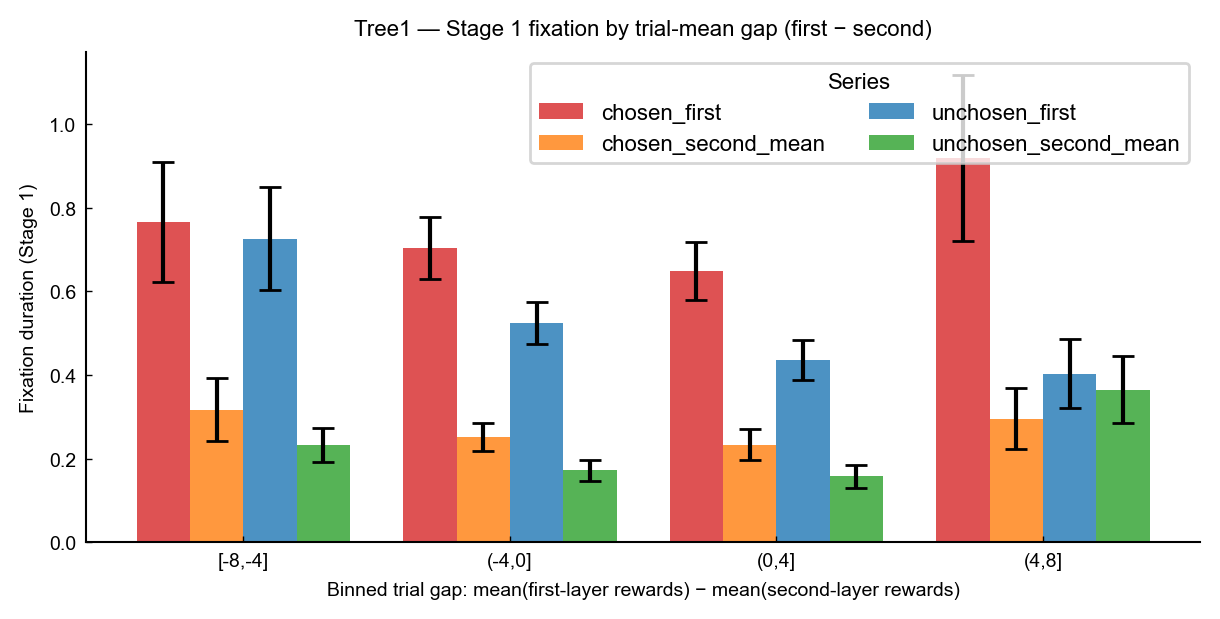

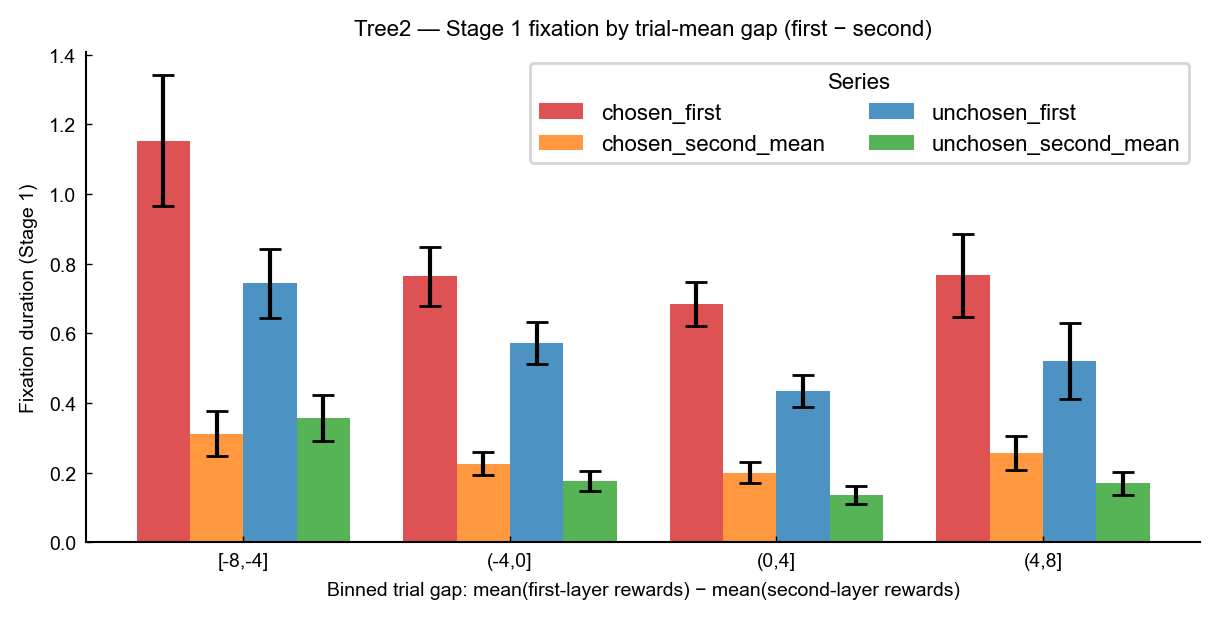

In [17]:
plot_stage1_binned_trial_gap_mean_first_minus_second_tree1(res)
plot_stage1_binned_trial_gap_mean_first_minus_second_tree2(res)

/var/folders/j5/y5g6mhcd7wg0lg4_wsdrql7r0000gn/T/ipykernel_61036/1266545210.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis', len(rewards_sorted))


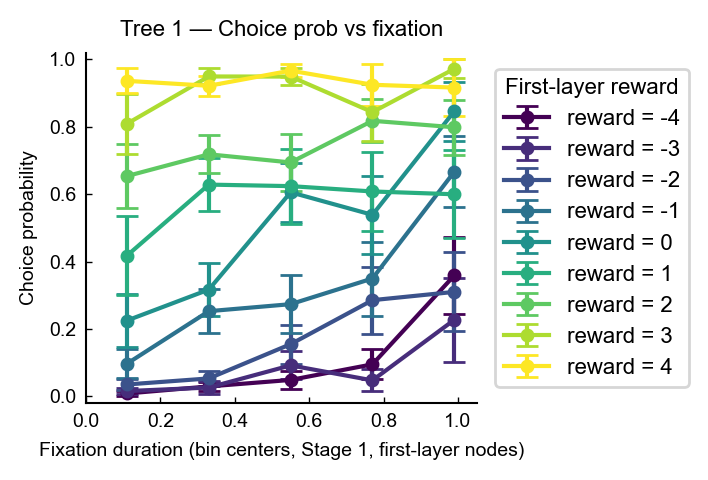

/var/folders/j5/y5g6mhcd7wg0lg4_wsdrql7r0000gn/T/ipykernel_61036/1266545210.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis', len(rewards_sorted))


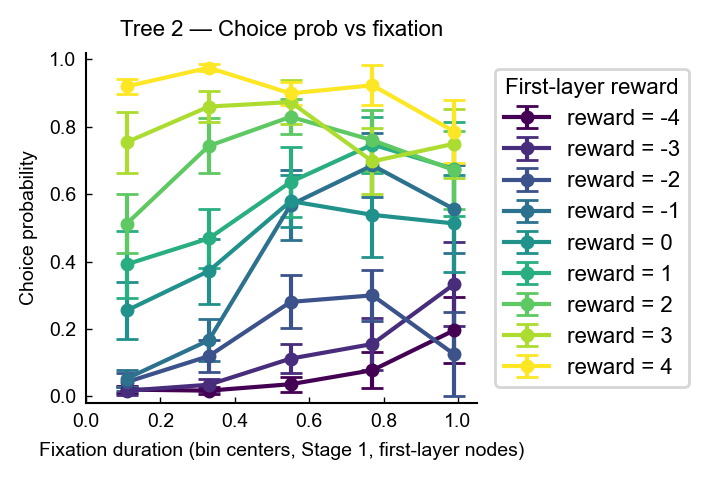

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib.cm import get_cmap

# -------- shared helpers --------
def _sem(x: pd.Series) -> float:
    n = x.count()
    return 0.0 if n <= 1 else float(x.std(ddof=1) / math.sqrt(n))

def _bin_edges_from_data(x: pd.Series, n_bins: int):
    q = np.linspace(0, 1, n_bins+1)
    edges = np.unique(x.quantile(q).to_numpy())
    if len(edges) < 3:  # fallback to equal-width if not enough unique quantiles
        mn, mx = float(x.min()), float(x.max())
        if mx == mn:  # degenerate
            mx = mn + 1.0
        edges = np.linspace(mn, mx, n_bins+1)
    return edges

def _plot_choice_prob_vs_fix_binned_core(df_sub: pd.DataFrame, title: str, bins=None, n_bins: int = 10):
    """
    df_sub: res filtered to stage==1 & node_identity in {L,R} & one tree_type
            columns: wid, trial_index, stage, node_identity, reward, fixation_duration, choice
    """
    # clean types
    df = df_sub.copy()
    df['reward'] = pd.to_numeric(df['reward'], errors='coerce')
    df['fixation_duration'] = pd.to_numeric(df['fixation_duration'], errors='coerce')
    df['choice'] = pd.to_numeric(df['choice'], errors='coerce')
    df = df.dropna(subset=['reward','fixation_duration','choice'])
    if df.empty:
        raise RuntimeError("No Stage 1 first-layer rows after cleaning.")

    # bins
    if bins is None:
        bins = _bin_edges_from_data(df['fixation_duration'], n_bins=n_bins)
    df['fix_bin'] = pd.cut(df['fixation_duration'], bins=bins, right=True, include_lowest=True)

    # per-participant mean(choice) in each (bin, reward)
    df_wid = (df.groupby(['wid','fix_bin','reward'], observed=True)['choice']
                .mean()
                .reset_index(name='choice_prob_wid'))

    # group mean ± SEM across participants
    stats = (df_wid.groupby(['fix_bin','reward'], observed=True)['choice_prob_wid']
                  .agg(mean='mean', sem=_sem, n='count')
                  .reset_index())
    if stats.empty:
        raise RuntimeError("No data in any bins — adjust bins or check input.")

    # x positions = bin centers
    def interval_center(iv):
        try:
            return 0.5 * (float(iv.left) + float(iv.right))
        except Exception:
            return np.nan
    stats['x'] = stats['fix_bin'].apply(interval_center)

    # color by reward
    rewards_sorted = np.sort(stats['reward'].unique())
    cmap = get_cmap('viridis', len(rewards_sorted))
    color_map = {r: cmap(i) for i, r in enumerate(rewards_sorted)}

    # plot
    fig, ax = plt.subplots(figsize=(3.65, 2.5))
    for r in rewards_sorted:
        sub = stats[stats['reward'] == r].sort_values('x')
        ax.errorbar(
            sub['x'].to_numpy(),
            sub['mean'].to_numpy(),
            yerr=sub['sem'].to_numpy(),
            fmt='o-', capsize=4, markersize=4,
            label=f"reward = {r:g}",
            color=color_map[r]
        )

    ax.set_xlabel('Fixation duration (bin centers, Stage 1, first-layer nodes)')
    ax.set_ylabel('Choice probability')
    ax.set_xlim(0, 1.05)
    ax.set_ylim(-0.02, 1.02)
    ax.set_title(title)
    ax.legend(
        title='First-layer reward',
        fontsize=8,
        title_fontsize=8,
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),  # 放在右边中间
        ncol=1
    )
    fig.subplots_adjust(right=0.78)
    ax.margins(x=0.05)
    plt.tight_layout()
    plt.show()


# -------- public functions --------
def plot_stage1_choice_prob_vs_fixation_binned_tree1_0to1(res: pd.DataFrame):
    needed = {'wid','trial_index','stage','node_identity','reward','fixation_duration','choice','tree_type'}
    missing = needed - set(res.columns)
    if missing:
        raise ValueError(f"`res` missing columns: {missing}")
    
    # 只保留 Tree1 + Stage1 + 第一层节点，并且 fixation_duration ≤ 1
    df_sub = res[(res['tree_type'] == 'tree1') &
                 (res['stage'] == 1) &
                 (res['node_identity'].isin(['L','R'])) &
                 (res['fixation_duration'] <= 1.2)]
    if df_sub.empty:
        raise RuntimeError("No Stage 1 first-layer data for tree1 with fixation ≤ 1.")
    
    # 定义 0–1 的 10 等分 bin
    bins = np.linspace(0, 1.1, 6)
    _plot_choice_prob_vs_fix_binned_core(
        df_sub,
        title='Tree 1 — Choice prob vs fixation',
        bins=bins
    )

def plot_stage1_choice_prob_vs_fixation_binned_tree2_0to1(res: pd.DataFrame):
    needed = {'wid','trial_index','stage','node_identity','reward','fixation_duration','choice','tree_type'}
    missing = needed - set(res.columns)
    if missing:
        raise ValueError(f"`res` missing columns: {missing}")
    
    df_sub = res[(res['tree_type'] == 'tree2') &
                 (res['stage'] == 1) &
                 (res['node_identity'].isin(['L','R'])) &
                 (res['fixation_duration'] <= 1.2)]
    if df_sub.empty:
        raise RuntimeError("No Stage 1 first-layer data for tree2 with fixation ≤ 1.")
    
    bins = np.linspace(0, 1.1, 6)
    _plot_choice_prob_vs_fix_binned_core(
        df_sub,
        title='Tree 2 — Choice prob vs fixation',
        bins=bins
    )


# ---- usage examples ----
plot_stage1_choice_prob_vs_fixation_binned_tree1_0to1(res)  # quantile bins (default n_bins=6)
plot_stage1_choice_prob_vs_fixation_binned_tree2_0to1(res)
# plot_stage1_choice_prob_vs_fixation_binned_tree1(res, bins=[0,100,200,300,400,500,600,700,800,900,1000])  # custom edges
# plot_stage1_choice_prob_vs_fixation_binned_tree2(res, bins=[0,100,200,300,400,500,600,700,800,900,1000])

/var/folders/j5/y5g6mhcd7wg0lg4_wsdrql7r0000gn/T/ipykernel_61036/186388135.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis', len(rewards_sorted))


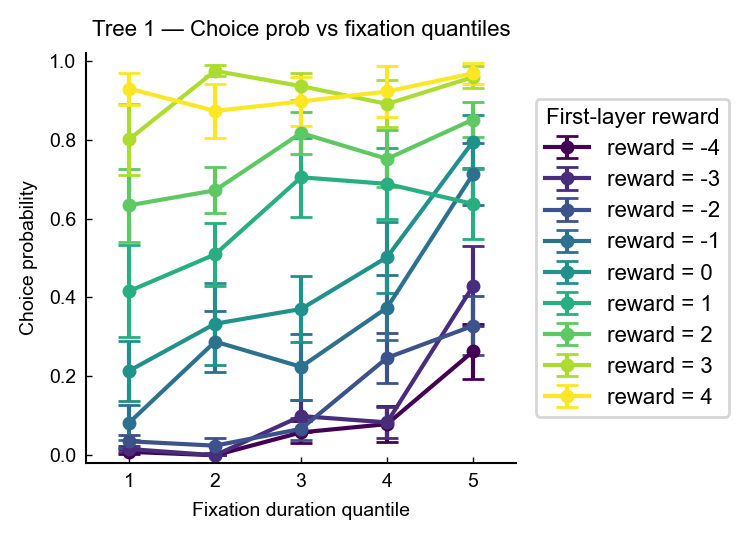

/var/folders/j5/y5g6mhcd7wg0lg4_wsdrql7r0000gn/T/ipykernel_61036/186388135.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis', len(rewards_sorted))


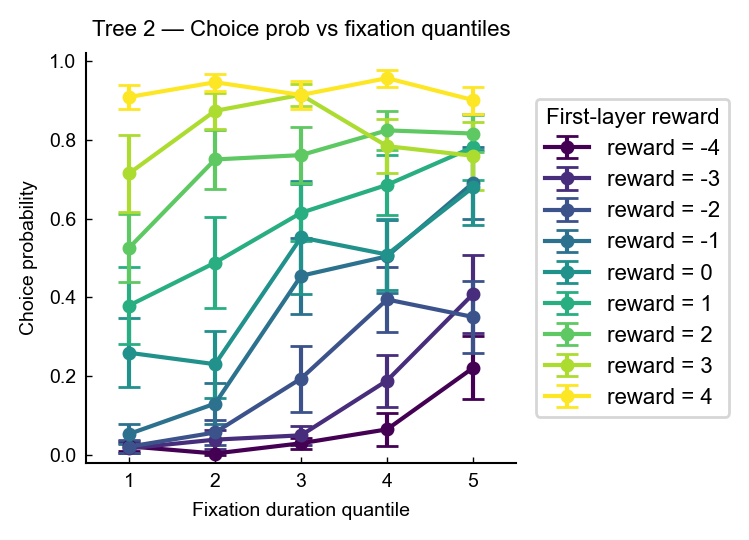

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib.cm import get_cmap

# ---- helper ----
def _sem(x: pd.Series) -> float:
    n = x.count()
    return 0.0 if n <= 1 else float(x.std(ddof=1) / math.sqrt(n))

def _quantile_bins_0to1(x: pd.Series, n_bins: int):
    """
    Build quantile bin edges for fixation duration restricted to [0,1].
    Returns pandas Interval categories and an array of integer bin indices (1..n_bins).
    """
    x_clip = x.clip(lower=0.0, upper=1.0)
    # quantile edges in [0,1]-clipped data
    q = np.linspace(0, 1, n_bins + 1)
    edges = np.unique(x_clip.quantile(q).to_numpy())
    if len(edges) < 3:
        # degenerate; fallback to equal width in [0,1]
        edges = np.linspace(0, 1, n_bins + 1)
    # ensure strictly increasing (handle potential duplicates by jittering minimally)
    for k in range(1, len(edges)):
        if edges[k] <= edges[k-1]:
            edges[k] = edges[k-1] + 1e-12
    # cut into quantile bins
    bins = pd.cut(x_clip, bins=edges, include_lowest=True, right=True)
    # quantile index (1..n_bins) based on the categorical codes
    q_idx = bins.cat.codes + 1  # -1 means NaN/outside; should not happen after clip
    return bins, q_idx

# ---- core: plot with Y = quantile bin (1..n_bins), X = choice probability ----
def _plot_choice_prob_vs_fix_quantile_core(df_sub: pd.DataFrame, title: str, n_bins: int = 10):
    df = df_sub.copy()
    df['reward'] = pd.to_numeric(df['reward'], errors='coerce')
    df['fixation_duration'] = pd.to_numeric(df['fixation_duration'], errors='coerce')
    df['choice'] = pd.to_numeric(df['choice'], errors='coerce')
    df = df.dropna(subset=['reward', 'fixation_duration', 'choice'])
    if df.empty:
        raise RuntimeError("No Stage 1 first-layer rows after cleaning.")

    _, q_idx = _quantile_bins_0to1(df['fixation_duration'], n_bins=n_bins)
    df['qbin'] = q_idx
    df = df[(df['qbin'] >= 1) & (df['qbin'] <= n_bins)]

    df_wid = (
        df.groupby(['wid', 'qbin', 'reward'], observed=True)['choice']
          .mean()
          .reset_index(name='choice_prob_wid')
    )

    stats = (
        df_wid.groupby(['qbin', 'reward'], observed=True)['choice_prob_wid']
              .agg(mean='mean', sem=_sem, n='count')
              .reset_index()
    )
    if stats.empty:
        raise RuntimeError("No data in any quantile bins — check data or bin count.")

    rewards_sorted = np.sort(stats['reward'].unique())
    cmap = get_cmap('viridis', len(rewards_sorted))
    color_map = {r: cmap(i) for i, r in enumerate(rewards_sorted)}

    fig, ax = plt.subplots(figsize=(3.85, 2.8))
    for r in rewards_sorted:
        sub = stats[stats['reward'] == r].sort_values('qbin')
        ax.errorbar(
            x=sub['qbin'].to_numpy(),               # 横轴: quantile index
            y=sub['mean'].to_numpy(),               # 纵轴: choice probability
            yerr=sub['sem'].to_numpy(),
            fmt='o-', capsize=4, markersize=4,
            label=f"reward = {r:g}",
            color=color_map[r]
        )

    ax.set_xlabel('Fixation duration quantile')
    ax.set_ylabel('Choice probability')
    ax.set_xlim(0.5, n_bins + 0.5)
    ax.set_ylim(-0.02, 1.02)
    ax.set_xticks(np.arange(1, n_bins + 1))
    ax.set_title(title)
    ax.legend(
        title='First-layer reward',
        fontsize=8,
        title_fontsize=8,
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        ncol=1
    )
    fig.subplots_adjust(right=0.78)
    plt.tight_layout()
    plt.show()

# ---- wrappers for tree1 / tree2 ----
def plot_stage1_choice_prob_vs_fix_quantile_tree1(res: pd.DataFrame, n_bins: int = 10):
    """
    Tree 1 only. Uses fixation_duration quantiles within [0,1] (n_bins bins).
    Y-axis = quantile index (1..n_bins), X-axis = choice probability, color = first-layer reward.
    """
    needed = {'wid','trial_index','stage','node_identity','reward','fixation_duration','choice','tree_type'}
    missing = needed - set(res.columns)
    if missing:
        raise ValueError(f"`res` missing columns: {missing}")
    df_sub = res[(res['tree_type'] == 'tree1') &
                 (res['stage'] == 1) &
                 (res['node_identity'].isin(['L','R']))]
    if df_sub.empty:
        raise RuntimeError("No Stage 1 first-layer data for tree1.")
    _plot_choice_prob_vs_fix_quantile_core(df_sub, title='Tree 1 — Choice prob vs fixation quantiles', n_bins=n_bins)

def plot_stage1_choice_prob_vs_fix_quantile_tree2(res: pd.DataFrame, n_bins: int = 10):
    """
    Tree 2 only. Uses fixation_duration quantiles within [0,1] (n_bins bins).
    Y-axis = quantile index (1..n_bins), X-axis = choice probability, color = first-layer reward.
    """
    needed = {'wid','trial_index','stage','node_identity','reward','fixation_duration','choice','tree_type'}
    missing = needed - set(res.columns)
    if missing:
        raise ValueError(f"`res` missing columns: {missing}")
    df_sub = res[(res['tree_type'] == 'tree2') &
                 (res['stage'] == 1) &
                 (res['node_identity'].isin(['L','R']))]
    if df_sub.empty:
        raise RuntimeError("No Stage 1 first-layer data for tree2.")
    _plot_choice_prob_vs_fix_quantile_core(df_sub, title='Tree 2 — Choice prob vs fixation quantiles', n_bins=n_bins)


plot_stage1_choice_prob_vs_fix_quantile_tree1(res, n_bins=5)
plot_stage1_choice_prob_vs_fix_quantile_tree2(res, n_bins=5)